<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/german_credit_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
random.seed(42)
import os
import math
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from google.colab import files
import re

import warnings
warnings.filterwarnings('ignore')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# UTILS

## Sets of Features (aka data columns)

In [51]:
#Master Dataset
#FEATURES
META = ['clusters', 'new_clusters', 'Error_Type']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['Age', 'Single', 'Unemployed', 'LoanAmount']
#SEN = ['Gender_F', 'OwnsHouse'] #protected attributes
DUMMY = ['Gender_F', 'OwnsHouse', 'ForeignWorker']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['Age_scaled','Single_scaled', 'Unemployed_scaled',
               'LoanAmount_scaled']
#SEN_scaled = ['Gender_F_scaled', 'OwnsHouse_scaled']
DUMMY_scaled = ['Gender_F_scaled', 'OwnsHouse_scaled','ForeignWorker_scaled']

#SHAP FEATURES
SHAP_REG = ['Shap_Age','Shap_Single','Shap_Unemployed', 'Shap_LoanAmount']
#SHAP_SEN = ['Shap_Gender_F', 'Shap_OwnsHouse']
SHAP_DUMMY = ['Shap_Gender_F', 'Shap_OwnsHouse','Shap_ForeignWorker']

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_Age_scaled', 'Shap_Single_scaled', 'Shap_Unemployed_scaled',
                   'Shap_LoanAmount_scaled']
#SHAP_SEN_scaled = ['Shap_Gender_F_scaled', 'Shap_OwnsHouse_scaled']
SHAP_DUMMY_scaled = ['Shap_Gender_F_scaled', 'Shap_OwnsHouse_scaled', 'Shap_ForeignWorker_scaled']


## Utils for Data Prep

In [52]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [53]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY, col_label='Gender_F', numeric_values=False, short_label=SHORT_LABEL_Gender_F)
#data = undo_dummy(data, DUMMY, col_label='ForeignWorker', numeric_values=False, short_label=SHORT_LABEL_Foreignworker)

## Utils for Clustering

In [54]:
# Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

In [55]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    filter_tf = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[filter_tf]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)

## Utils for Results

### Recap

In [56]:
def make_recap(data_result, feature_set):
  # MAKE RECAP of cluster info
  # ...with error rates
  res = data_result[['clusters', 'errors']]

  # ...with cluster size
  temp = data_result[['clusters']]
  temp['count'] = 1
  recap = temp.groupby(['clusters'], as_index=False).sum()

  # ...with number of error
  recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

  # ...with 1-vs-All error diff
  recap['error_rate'] = res.groupby(['clusters']).mean()
  # recap['std'] = (recap['error_rate'] * (1-recap['error_rate']))/recap['count']
  # recap['std'] = recap['std'].apply(np.sqrt)

  # Prepare Quality metrics
  diff_vs_rest = []
  # diff_std = []
  diff_p =[]

  foreign_prop = []
  foreign_diff = []
  foreign_p = []

  houseowner_prop = []
  houseowner_diff = []
  houseowner_p = []

  female_prop = []
  female_diff = []
  female_p = []

  silhouette = []

  # Get individual silhouette scores
  clusters = data_result['clusters']
  if(len(recap['clusters'].unique()) > 1):
    silhouette_val = silhouette_samples(data_result[feature_set], clusters)

  for c in recap['clusters']:
    # Get in-cluster data
    c_data = data_result.loc[data_result['clusters'] == c]
    c_count = recap['count'][c]

    # Get out-of-cluster data
    rest_data = data_result.loc[data_result['clusters'] != c]
    # Check if no other cluster
    if(len(rest_data) == 0):
      diff_vs_rest.append(np.nan)
      # diff_std.append(np.nan)
      diff_p.append(np.nan)

      foreign_prop.append(np.nan)
      foreign_diff.append(np.nan)
      foreign_p.append(np.nan)

      houseowner_prop.append(np.nan)
      houseowner_diff.append(np.nan)
      houseowner_p.append(np.nan)

      female_prop.append(np.nan)
      female_diff.append(np.nan)
      female_p.append(np.nan)

      silhouette.append(np.nan)
      break

    # Add silhouette score
    silhouette.append(silhouette_val[clusters == c].mean())

    rest_recap = recap.loc[recap['clusters'] != c]
    rest_count = rest_recap['count'].sum()

    #### Quick test: differences in error rates
    # Get error rate difference 1-vs-rest
    rest_n_error = rest_recap['n_error'].sum()
    rest_rate = rest_n_error / rest_count
    diff_vs_rest.append(recap['error_rate'][c] - rest_rate)

    # ...with std deviation of error differences
    # std_rest = (rest_rate * (1-rest_rate))/rest_count
    # std_rest = np.sqrt(std_rest)
    # diff_std.append(recap['std'][c] + std_rest)

    # ...with Poisson stat testprint('Zero!')
    # Deal with splits with 0 error (by using either number of errors (FN or FP), or number of correct classifications (TP or TN))
    if((recap['n_error'][c] < 1) | (recap['count'][c] < 1) | (rest_n_error < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(recap['count'][c] - recap['n_error'][c], recap['count'][c], rest_count - rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
      diff_p.append(round(res.pvalue, 3))

    ##### Sensitive features (GENDER, FOREIGN WORKER, HOUSE OWNER) -- ['Gender_F_scaled', 'ForeignWorker_scaled', ''OwnsHouse_scaled'' ]
    ### ForeignWorker
    rest_n_ForeignWorker = rest_data['ForeignWorker'].sum()
    rest_prop_ForeignWorker = rest_n_ForeignWorker / rest_count

    c_n_ForeignWorker = c_data['ForeignWorker'].sum()
    c_prop_ForeignWorker = c_n_ForeignWorker / c_count

    foreign_prop.append(c_prop_ForeignWorker)
    foreign_diff.append(c_prop_ForeignWorker - rest_prop_ForeignWorker)

    # Deal with splits with 0 foreign workers (by using either number of foreign workers, or number of non- foreign workers)
    if((c_n_ForeignWorker < 1) | (c_count < 1) | (rest_n_ForeignWorker < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_ForeignWorker, c_count, rest_count - rest_n_ForeignWorker, rest_count)
      foreign_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_ForeignWorker, c_count, rest_n_ForeignWorker, rest_count)
      foreign_p.append(round(res.pvalue, 3))

    ### House owner
    rest_n_houseowner = rest_data['OwnsHouse'].sum()
    rest_prop_houseowner = rest_n_houseowner / rest_count

    c_n_houseowner = c_data['OwnsHouse'].sum()
    c_prop_houseowner = c_n_houseowner / c_count

    houseowner_prop.append(c_prop_houseowner)
    houseowner_diff.append(c_prop_houseowner - rest_prop_houseowner)

    # Deal with splits with 0 House Owners (by using either number of House Ownser, or number of non-House owners)
    if((c_n_houseowner < 1) | (c_count < 1) | (rest_n_houseowner < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_houseowner, c_count, rest_count - rest_n_houseowner, rest_count)
      houseowner_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_houseowner, c_count, rest_n_houseowner, rest_count)
      houseowner_p.append(round(res.pvalue, 3))

    ##### Gender
    rest_n_female = rest_data['Gender_F'].sum()
    rest_prop_female = rest_n_female/ rest_count

    c_n_female = c_data['Gender_F'].sum()
    c_prop_female = c_n_female / c_count

    female_prop.append(c_prop_female)
    female_diff.append(c_prop_female - rest_prop_female)

    # Deal with splits with 0 females(by using either number of females, or number of males)
    if((c_n_female < 1) | (c_count < 1) | (rest_n_female < 1) | (rest_count < 1)):
      res = stats.poisson_means_test(c_count - c_n_female, c_count, rest_count - rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))
    else:
      res = stats.poisson_means_test(c_n_female, c_count, rest_n_female, rest_count)
      female_p.append(round(res.pvalue, 3))

  recap['diff_vs_rest'] = np.around(diff_vs_rest, 3)
  # recap['diff_std'] = np.around(diff_std, 3)
  recap['diff_p'] = diff_p

  recap['foreign_prop'] = np.around(foreign_prop, 3)
  recap['foreign_diff'] = np.around(foreign_diff, 3)
  recap['foreign_p'] = foreign_p

  recap['houseowner_prop'] = np.around(houseowner_prop, 3)
  recap['houseowner_diff'] = np.around(houseowner_diff, 3)
  recap['houseowner_p'] = houseowner_p

  recap['female_prop'] = np.around(female_prop, 3)
  recap['female_diff'] = np.around(female_diff, 3)
  recap['female_p'] = female_p

  recap['silhouette'] = silhouette

  recap['error_rate'] = np.around(recap['error_rate'] , 3)
  # recap['std'] = np.around(recap['std'] , 3)

  recap.rename(columns={'clusters':'c'}, inplace=True)
  #print(recap.sort_values(by=['diff_p']))

  return(recap)

### Chi-Square Tests

In [79]:
def make_chi_tests(results):
  chi_res = {'cond_descr': [],
            'cond_name': [],
            'error': [],
            'foreign': [],
            'house': [],
            'gender': []}

  for i in range(0, len(results['cond_name'])):
    chi_res['cond_descr'].append(results['cond_descr'][i])
    chi_res['cond_name'].append(results['cond_name'][i])
    data = results['cond_res'][i]
    recap = results['cond_recap'][i]

    if(len(recap['diff_p']) == 1):
      chi_res['error'].append(np.nan)
      chi_res['foreign'].append(np.nan)
      chi_res['house'].append(np.nan)
      chi_res['gender'].append(np.nan)
      continue

    # Test error differences
    test_data = recap[['count', 'n_error']].copy(deep=True)

    test_data['count'] = test_data['count'] - test_data['n_error']
    test_data = test_data.rename(columns={"count": "n_correct"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['error'].append(round(test_res.pvalue, 6))

    #print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test gender differences
    test_data = recap[['count', 'female_prop']].copy(deep=True)

    test_data['female_prop'] = round(test_data['count'] * test_data['female_prop'])
    test_data = test_data.rename(columns={"female_prop": "female_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['female_n']
    test_data = test_data.rename(columns={"count": "male_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['gender'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test Foreign worker differences
    test_data = recap[['count', 'foreign_prop']].copy(deep=True)

    test_data['foreign_prop'] = round(test_data['count'] * test_data['foreign_prop'])
    test_data = test_data.rename(columns={"foreign_prop": "foreign_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['foreign_n']
    test_data = test_data.rename(columns={"count": "not_foreign_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['foreign'].append(round(test_res.pvalue, 6))

    # print(test_data)
    # print(round(test_res.pvalue, 6))

    # Test House owner differences
    test_data = recap[['count', 'houseowner_prop']].copy(deep=True)

    test_data['houseowner_prop'] = round(test_data['count'] * test_data['houseowner_prop'])
    test_data = test_data.rename(columns={"houseowner_prop": "houseowner_n"}).astype(int)

    test_data['count'] = test_data['count'] - test_data['houseowner_n']
    test_data = test_data.rename(columns={"count": "not_houseowner_n"})

    test_data = test_data.transpose()
    test_res = chi2_contingency(test_data)
    chi_res['house'].append(test_res.pvalue)

    # print(test_data)
    # print(round(test_res.pvalue, 6))'''

  return(pd.DataFrame(chi_res))

### All Quality Metrics

In [83]:
def recap_quali_metrics(chi_res, results, exp_condition):
  all_quali = {'cond_descr': chi_res['cond_descr'],
            'cond_name': chi_res['cond_name'],
            'error': chi_res['error'],
            'foreign': chi_res['foreign'],
            'house': chi_res['house'],
            'gender': chi_res['gender'],
            'silhouette': []}

  for i in range(0, len(chi_res['cond_name'])):
    data = results['cond_res'][i]
    feature_set = exp_condition['feature_set'][i]
    clusters = data['clusters']
    recap = results['cond_recap'][i]
    if(len(recap['diff_p']) == 1):
      all_quali['silhouette'].append(np.nan)
      continue
    silhouette_indiv = silhouette_samples(data[feature_set], clusters)
    silhouette_avg = silhouette_indiv.mean()
    all_quali['silhouette'].append(silhouette_avg)

  return(pd.DataFrame(all_quali))

## UTILS for Viz

In [59]:
def tsne_plot_wClusters(data, title, perplexity, learning_rate, n_iter, alpha, size, tsne_columns, fig_prefix):
  # Extract features for t-SNE and drop other_columns
  tsne_features = data[tsne_columns]
  other_columns = [col for col in data.columns if col not in tsne_features]
  other_features = data[other_columns]

  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
  tsne_result = tsne.fit_transform(tsne_features)
  tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

  temp_dataset = tsne_df.join(other_features, how='left')

  # Create scatterplot using seaborn
  scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, s=size,
                                hue="clusters", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  plt.savefig(fig_prefix+re.sub(' +', '', title)+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

# K-MEANS CLUSTERING

In [60]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = None,
                min_acceptable_cluster_prop = None,
                min_acceptable_error_diff = None,
                max_iter=300,
                random_state=None):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs, random_state=42).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.labels_

      # KEEP CLUSTER OR NOT
      # ...are cluster size large enough?
      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad split: too small')
        banned_clusters.append(x)
        continue

      # ...is error rate difference large enough?
      e0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      e1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if(abs(e0 - e1) < min_acceptable_error_diff):
        #print('Bad split: same error')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# SETUP EXPERIMENTS

### Prepare Data

In [61]:
credit = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks/credit_all.csv')


In [62]:
# Split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(credit)
TNFP_data = subset_TN_FP(credit)

In [63]:
# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()


In [64]:
if TPFN_data.empty or TNFP_data.empty:
    print("Dataframe is empty after dropping NA. Exiting.")

In [65]:
#print(TNFP_data['errors'])

### Set experimental conditions

In [66]:
##### Make and name the sets of features to experiment with
feature_set_name = []
feature_set_descr = []
feature_set = []

######### BASELINE HBAC
### Does adding SHAP help the clustering?
# Baseline (Mitzal-Radheka)
feature_set_name.append(f'+REG +SEN  -err     -shap')
feature_set_descr.append('Baseline')
feature_set.append(REG_scaled + DUMMY_scaled)

# Baseline with Error (Selma)
feature_set_name.append('+REG +SEN +ERR  -shap')
feature_set_descr.append('Baseline with Error')
feature_set.append(REG_scaled + DUMMY_scaled + ERROR_scaled)

# Adding SHAP values to Baseline (Mirthe;)
feature_set_name.append('+REG +SEN  -err    +SHAP')
feature_set_descr.append('Baseline with SHAP')
feature_set.append(REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled)

feature_set_name.append('+REG +SEN +ERR  +SHAP')
feature_set_descr.append('Baseline with SHAP & Error')
feature_set.append(REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled + ERROR_scaled)


############ SHAP-ONLY HBAC
### Does SHAP alone allow to identify clusters?
# Using only SHAP values
feature_set_name.append('-reg    -sen    -err     +SHAP')
feature_set_descr.append('SHAP only')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP')
feature_set_descr.append('SHAP only with Error')
feature_set.append(SHAP_REG_scaled + SHAP_DUMMY_scaled + ERROR_scaled)


############ ONLY SENSITIVE FEATURES
### Do sensitive features alone allow to identify clusters?
# Using only Sensitive features
feature_set_name.append('-reg    +SEN  -err     -shap')
feature_set_descr.append('Sensitive features only')
feature_set.append(DUMMY_scaled)

feature_set_name.append('-reg    +SEN +ERR   -shap')
feature_set_descr.append('Sensitive features with Error')
feature_set.append(DUMMY_scaled + ERROR_scaled)

### Does adding SHAP help the clustering based on sensitive features?
# Using Sensitive features with SHAP values
feature_set_name.append('-reg    +SEN  -err     +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP')
feature_set.append(DUMMY_scaled + SHAP_DUMMY_scaled)

feature_set_name.append('-reg    +SEN +ERR  +SHAP_S')
feature_set_descr.append('Sensitive features with SHAP & Error')
feature_set.append(DUMMY_scaled + SHAP_DUMMY_scaled + ERROR_scaled)

# Using only SHAP of Sensitive features
feature_set_name.append('-reg    -sen    -err     +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_DUMMY_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_S')
feature_set_descr.append('Only SHAP of Sensitive features')
feature_set.append(SHAP_DUMMY_scaled + ERROR_scaled)


############ ONLY REGULAR FEATURES
#conditons without sensitive to check how much it explains the results
feature_set_name.append('+REG -sen    -err     -shap')
feature_set_descr.append('REG Only')
feature_set.append(REG_scaled)

feature_set_name.append('+REG -sen    +ERR  -shap')
feature_set_descr.append('REG & ERROR')
feature_set.append(REG_scaled + ERROR_scaled)

feature_set_name.append('+REG -sen    -err     +SHAP_R')
feature_set_descr.append('REG & SHAP')
feature_set.append(SHAP_REG_scaled + REG_scaled) # ERROR FIXED

feature_set_name.append('+REG -sen    +ERR  +SHAP_R')
feature_set_descr.append('REG, ERROR & SHAP')
feature_set.append(SHAP_REG_scaled + REG_scaled + ERROR_scaled) # ERROR FIXED

# Using only SHAP of Regular features
feature_set_name.append('-reg    -sen    -err     +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features')
feature_set.append(SHAP_REG_scaled)

feature_set_name.append('-reg    -sen    +ERR  +SHAP_R')
feature_set_descr.append('Only SHAP of Regular features + Error')
feature_set.append(SHAP_REG_scaled + ERROR_scaled)

exp_condition = pd.DataFrame({'feature_set_descr': feature_set_descr,
                              'feature_set_name': feature_set_name,
                              'feature_set': feature_set})
exp_condition

feature_set_descr                  feature_set_name  \
0                                Baseline         +REG +SEN  -err     -shap   
1                     Baseline with Error             +REG +SEN +ERR  -shap   
2                      Baseline with SHAP          +REG +SEN  -err    +SHAP   
3              Baseline with SHAP & Error             +REG +SEN +ERR  +SHAP   
4                               SHAP only    -reg    -sen    -err     +SHAP   
5                    SHAP only with Error       -reg    -sen    +ERR  +SHAP   
6                 Sensitive features only      -reg    +SEN  -err     -shap   
7           Sensitive features with Error         -reg    +SEN +ERR   -shap   
8            Sensitive features with SHAP    -reg    +SEN  -err     +SHAP_S   
9    Sensitive features with SHAP & Error        -reg    +SEN +ERR  +SHAP_S   
10        Only SHAP of Sensitive features  -reg    -sen    -err     +SHAP_S   
11        Only SHAP of Sensitive features     -reg    -sen    +ERR  +SHAP_S   
12                               REG Only       +REG -sen    -err     -shap   
13                            REG & ERROR          +REG -sen    +ERR  -shap   
14                             REG & SHAP     +REG -sen    -err     +SHAP_R   
15                      REG, ERROR & SHAP        +REG -sen    +ERR  +SHAP_R   
16          Only SHAP of Regular features  -reg    -sen    -err     +SHAP_R   
17  Only SHAP of Regular features + Error     -reg    -sen    +ERR  +SHAP_R   

                                          feature_set  
0   [Age_scaled, Single_scaled, Unemployed_scaled,...  
1   [Age_scaled, Single_scaled, Unemployed_scaled,...  
2   [Age_scaled, Single_scaled, Unemployed_scaled,...  
3   [Age_scaled, Single_scaled, Unemployed_scaled,...  
4   [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...  
5   [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...  
6   [Gender_F_scaled, OwnsHouse_scaled, ForeignWor...  
7   [Gender_F_scaled, OwnsHouse_scaled, ForeignWor...  
8   [Gender_F_scaled, OwnsHouse_scaled, ForeignWor...  
9   [Gender_F_scaled, OwnsHouse_scaled, ForeignWor...  
10  [Shap_Gender_F_scaled, Shap_OwnsHouse_scaled, ...  
11  [Shap_Gender_F_scaled, Shap_OwnsHouse_scaled, ...  
12  [Age_scaled, Single_scaled, Unemployed_scaled,...  
13  [Age_scaled, Single_scaled, Unemployed_scaled,...  
14  [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...  
15  [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...  
16  [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...  
17  [Shap_Age_scaled, Shap_Single_scaled, Shap_Une...

# TNFP RESULTS


### Execute experiments

In [77]:
##### HBAC parameters
min_splittable_cluster_prop = 0.01 #0.05 #0.03
min_acceptable_cluster_prop = 0.03 #0.05 #0.03, 0.01
min_acceptable_error_diff = 0.005 # 0,01, 0.005

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_kmeans(TNFP_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

# Calculate and print cluster sizes
for i, res in enumerate(results['cond_res']):
  cluster_sizes = res['clusters'].value_counts().to_dict()  # Get cluster sizes
  print(f"Condition {results['cond_name'][i]} - Cluster sizes: {cluster_sizes}")


Condition +REG +SEN  -err     -shap - Cluster sizes: {7: 22, 3: 19, 11: 17, 0: 15, 1: 14, 2: 13, 10: 9, 6: 9, 4: 8, 8: 6, 5: 5, 9: 5}
Condition +REG +SEN +ERR  -shap - Cluster sizes: {14: 16, 2: 16, 11: 14, 1: 14, 12: 11, 0: 10, 4: 9, 13: 7, 5: 6, 7: 6, 9: 6, 8: 6, 3: 6, 6: 6, 15: 5, 10: 4}
Condition +REG +SEN  -err    +SHAP - Cluster sizes: {2: 37, 1: 34, 0: 23, 4: 21, 5: 9, 6: 8, 7: 6, 3: 4}
Condition +REG +SEN +ERR  +SHAP - Cluster sizes: {2: 37, 4: 23, 6: 22, 1: 21, 5: 11, 0: 10, 7: 8, 8: 6, 3: 4}
Condition -reg    -sen    -err     +SHAP - Cluster sizes: {0: 80, 1: 44, 2: 18}
Condition -reg    -sen    +ERR  +SHAP - Cluster sizes: {0: 53, 1: 31, 2: 27, 4: 13, 3: 12, 5: 6}
Condition -reg    +SEN  -err     -shap - Cluster sizes: {1: 73, 2: 25, 0: 25, 3: 19}
Condition -reg    +SEN +ERR   -shap - Cluster sizes: {0: 51, 7: 22, 2: 16, 6: 15, 3: 14, 5: 11, 4: 9, 1: 4}
Condition -reg    +SEN  -err     +SHAP_S - Cluster sizes: {2: 50, 7: 23, 5: 19, 4: 15, 3: 13, 0: 11, 1: 6, 6: 5}
Condition 

### Chi-Square Tests TNFP data

In [80]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

error   foreign     house    gender
cond_name                                                               
+REG +SEN  -err     -shap         0.000047  0.665488  0.000000  0.000000
+REG +SEN +ERR  -shap             0.000257  0.926525  0.000000  0.000000
+REG +SEN  -err    +SHAP          0.005916  0.897823  0.009728  0.000000
+REG +SEN +ERR  +SHAP             0.023925  0.942952  0.031956  0.000000
-reg    -sen    -err     +SHAP    0.434212  0.676889  0.185903  0.277750
-reg    -sen    +ERR  +SHAP       0.385230  0.890012  0.195251  0.027223
-reg    +SEN  -err     -shap      0.000409  0.812886  0.000000  0.000000
-reg    +SEN +ERR   -shap         0.000289  0.970219  0.000000  0.000000
-reg    +SEN  -err     +SHAP_S    0.003598  0.967524  0.000000  0.000000
-reg    +SEN +ERR  +SHAP_S        0.000480  0.997026  0.000000  0.000000
-reg    -sen    -err     +SHAP_S  0.434212  0.676889  0.185903  0.277750
-reg    -sen    +ERR  +SHAP_S     0.385230  0.890012  0.195251  0.027223
+REG -sen    -err     -shap       0.003570  0.014989  0.334351  0.000000
+REG -sen    +ERR  -shap          0.011411  0.866409  0.094199  0.000000
+REG -sen    -err     +SHAP_R     0.087733  0.006719  0.101102  0.000000
+REG -sen    +ERR  +SHAP_R        0.455177  0.773843  0.094872  0.000000
-reg    -sen    -err     +SHAP_R  0.434212  0.676889  0.185903  0.277750
-reg    -sen    +ERR  +SHAP_R     0.385230  0.890012  0.195251  0.027223

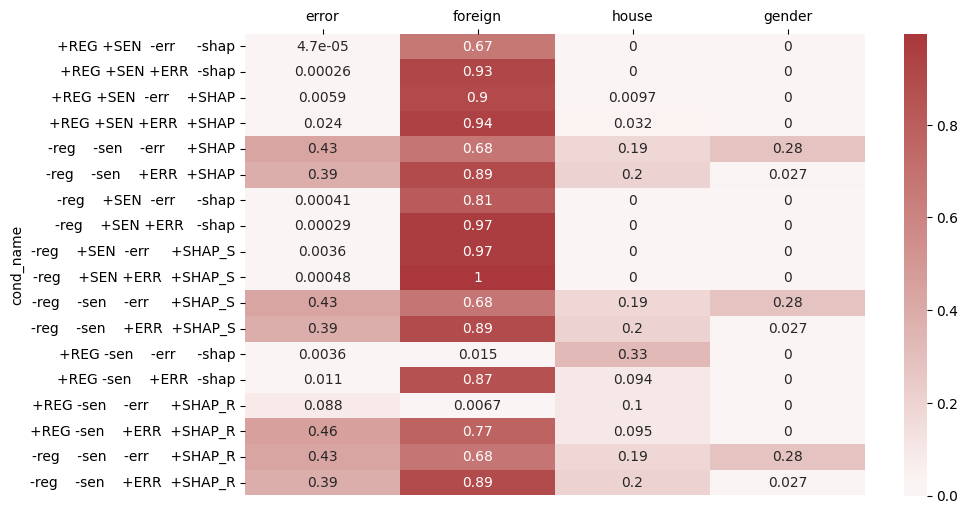

In [81]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

### All Quality Metrics TNFP data

In [84]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

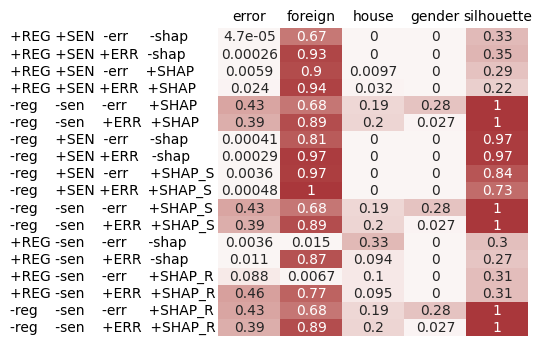

In [85]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TNFP_Kmeans.png', bbox_inches='tight', pad_inches=0)
files.download('TNFP_Kmeans.png')
plt.show()

# DETAILED TNFP RESULTS

## One-vs-All cluster comparison TNFP data

0


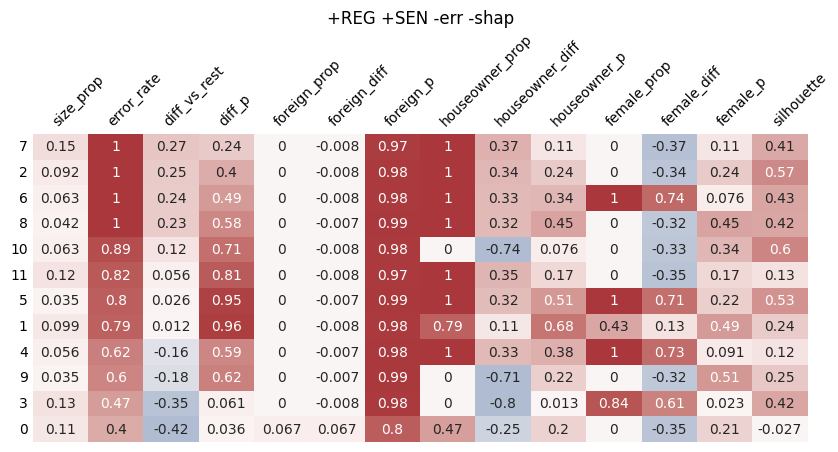

1


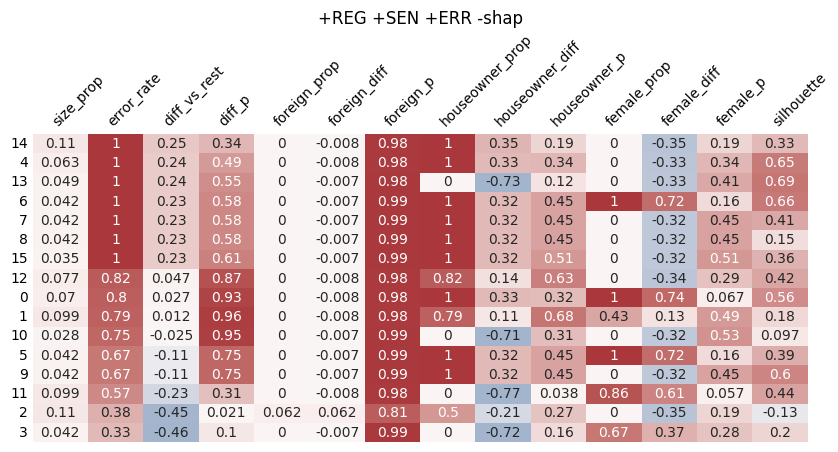

2


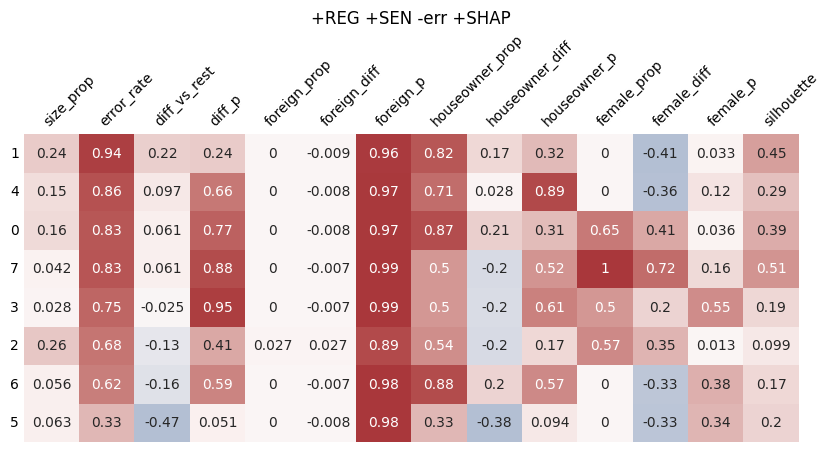

3


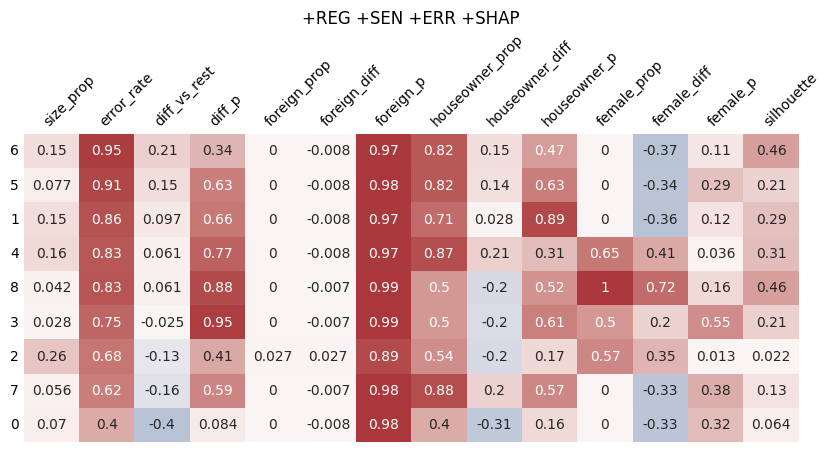

4


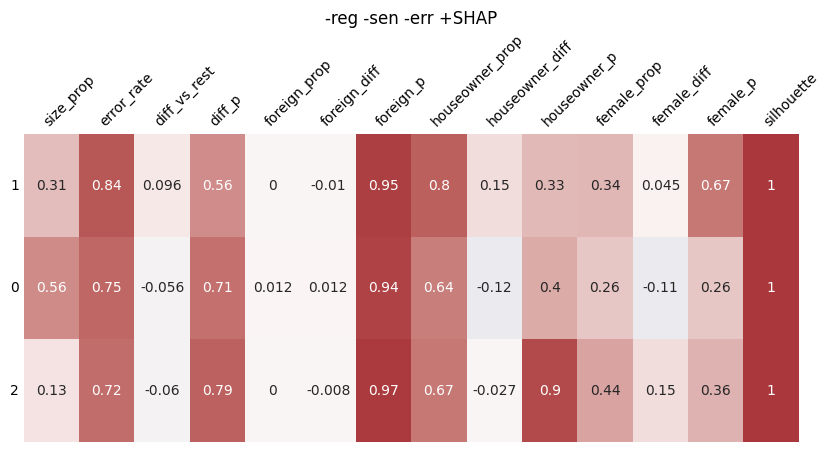

5


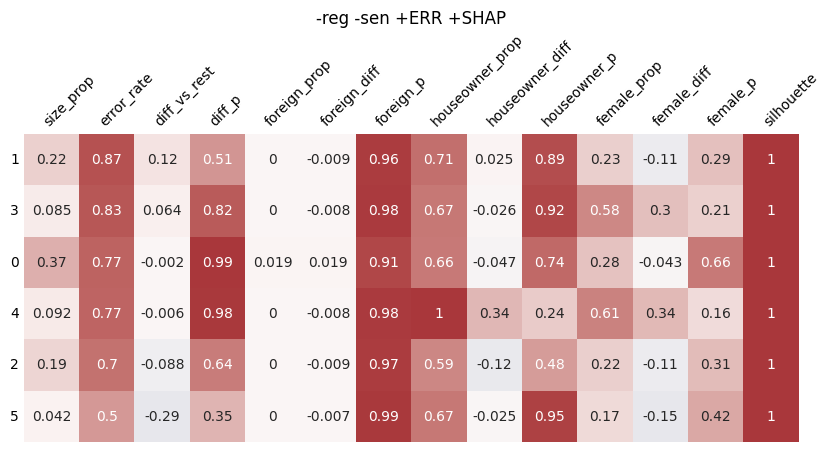

6


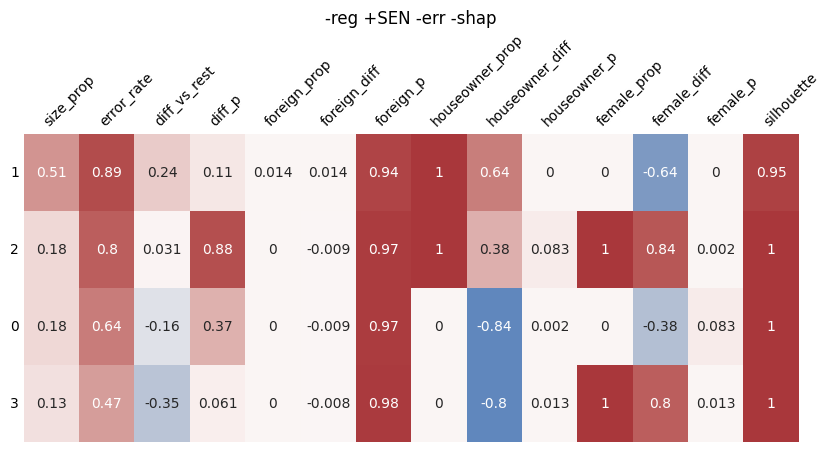

7


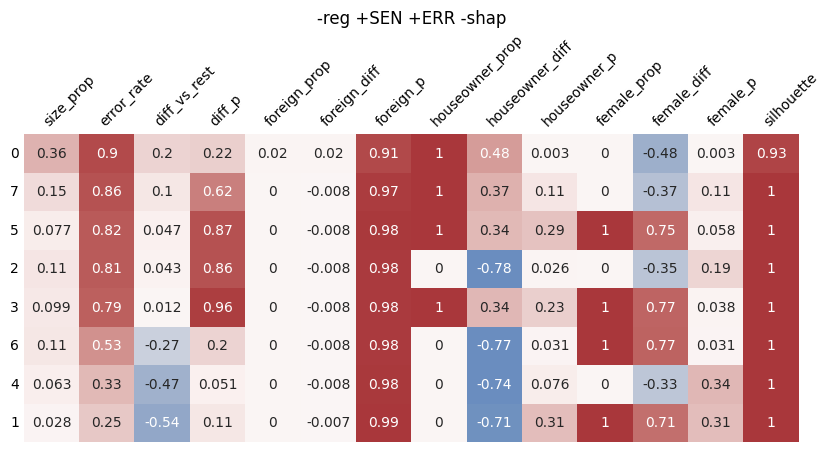

8


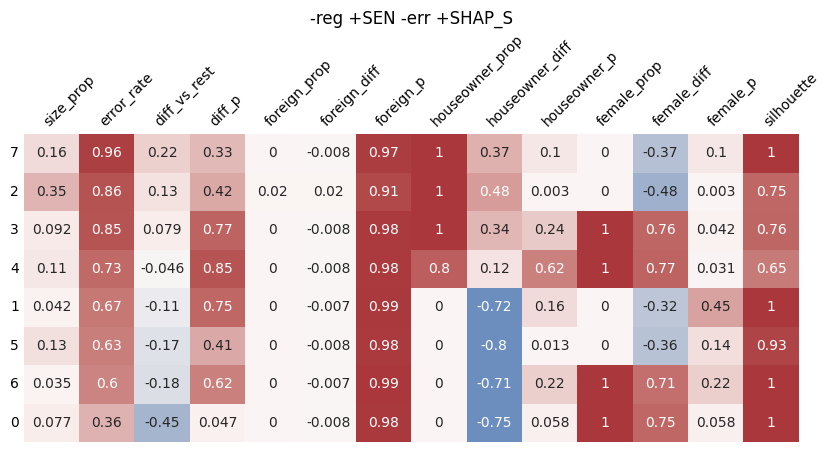

9


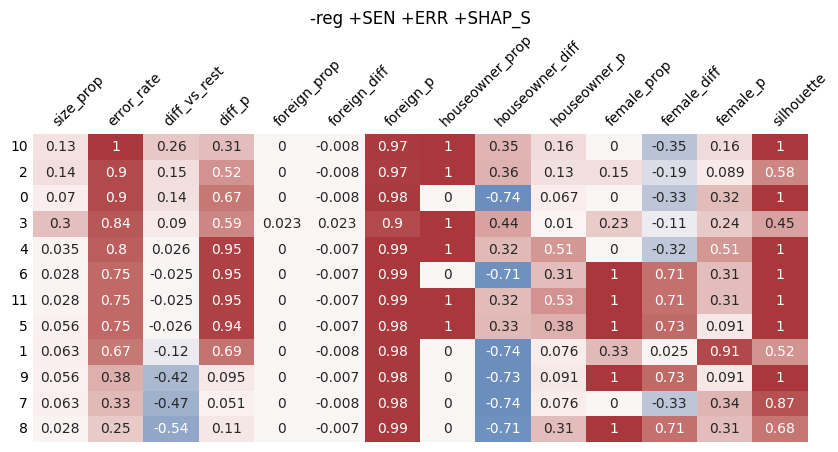

10


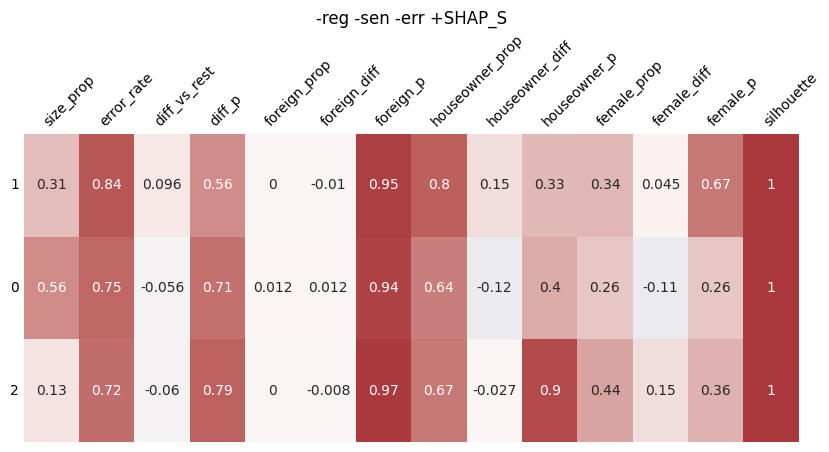

11


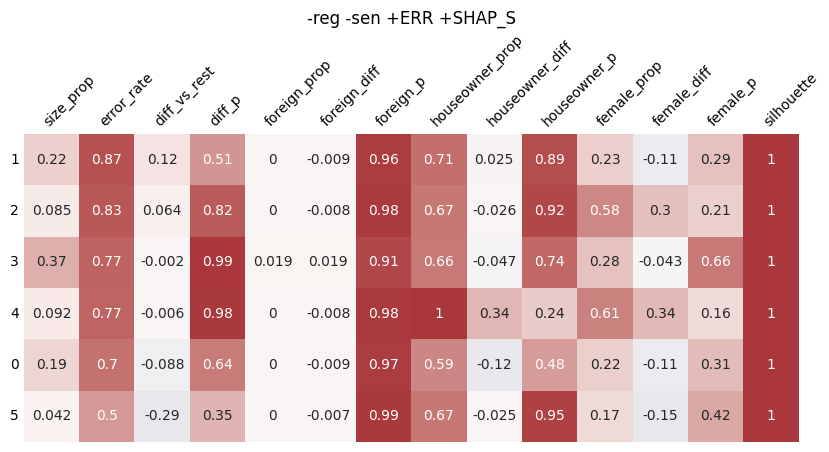

12


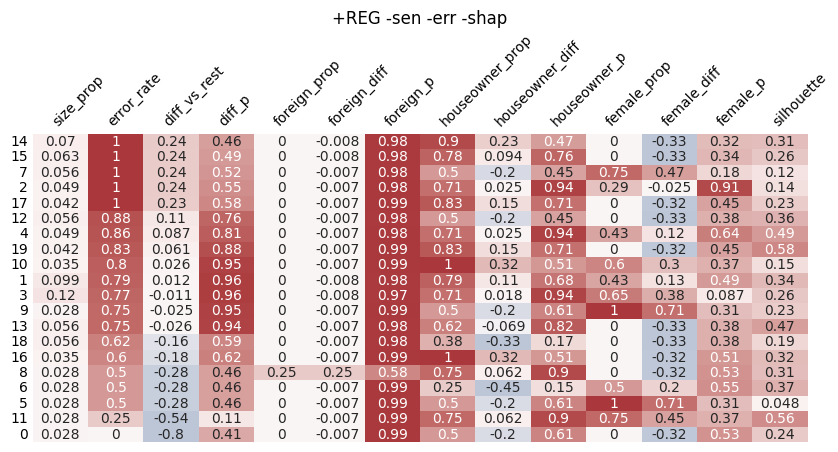

13


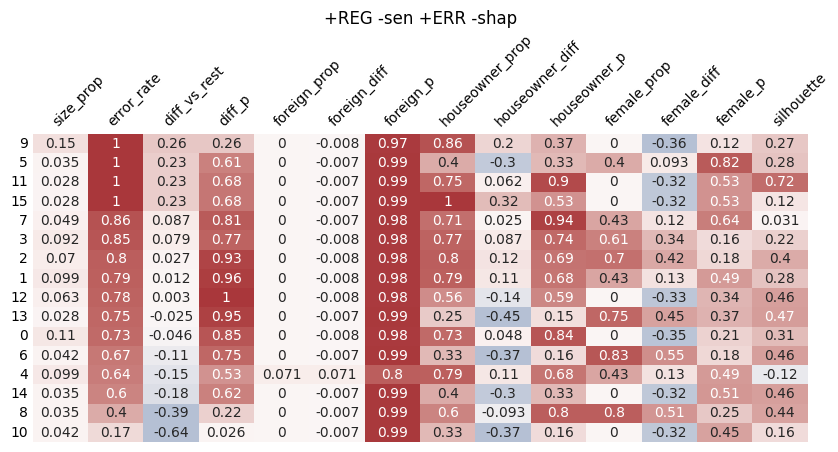

14


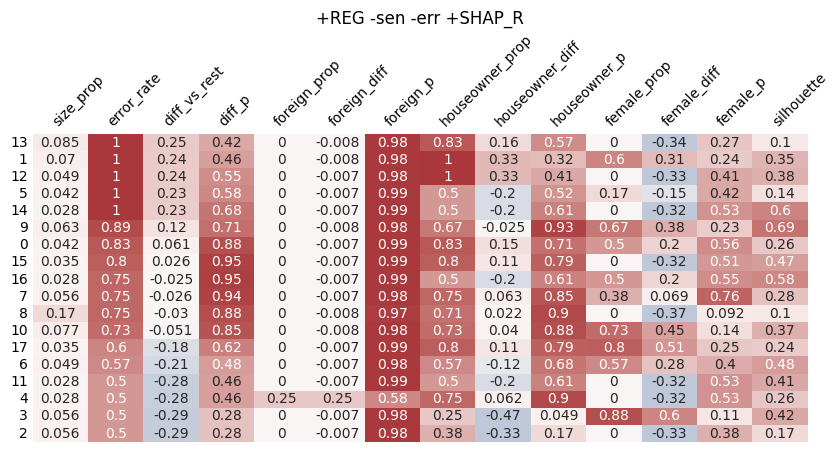

15


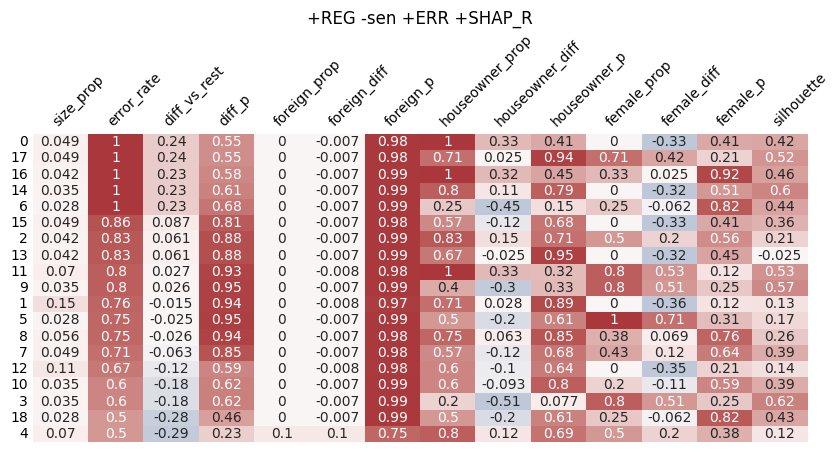

16


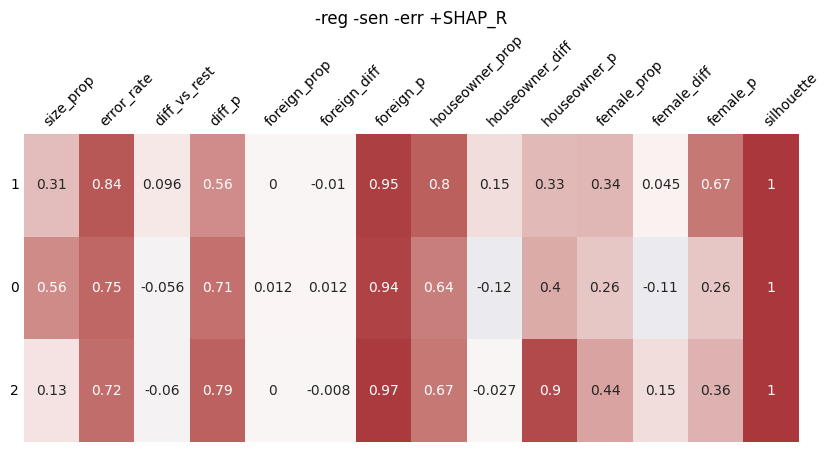

17


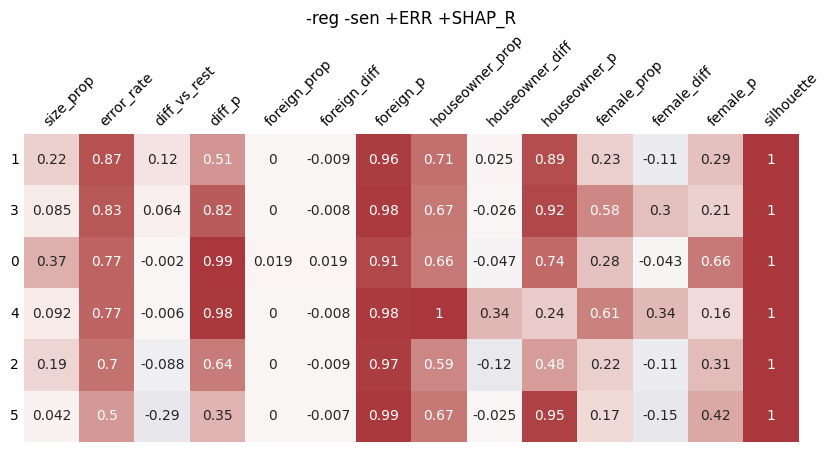

In [86]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

## t-SNE TNFP data

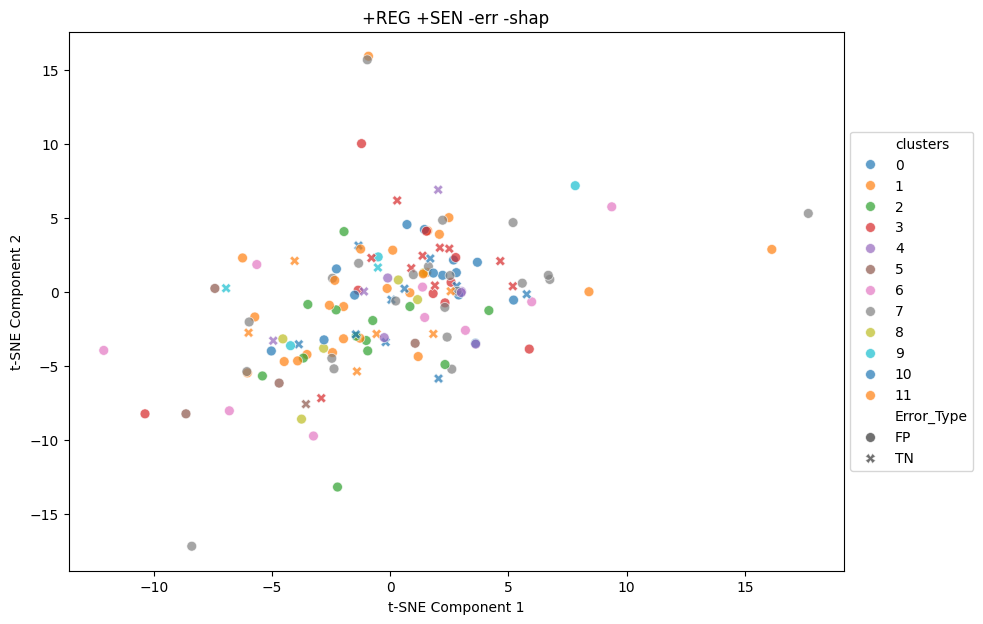

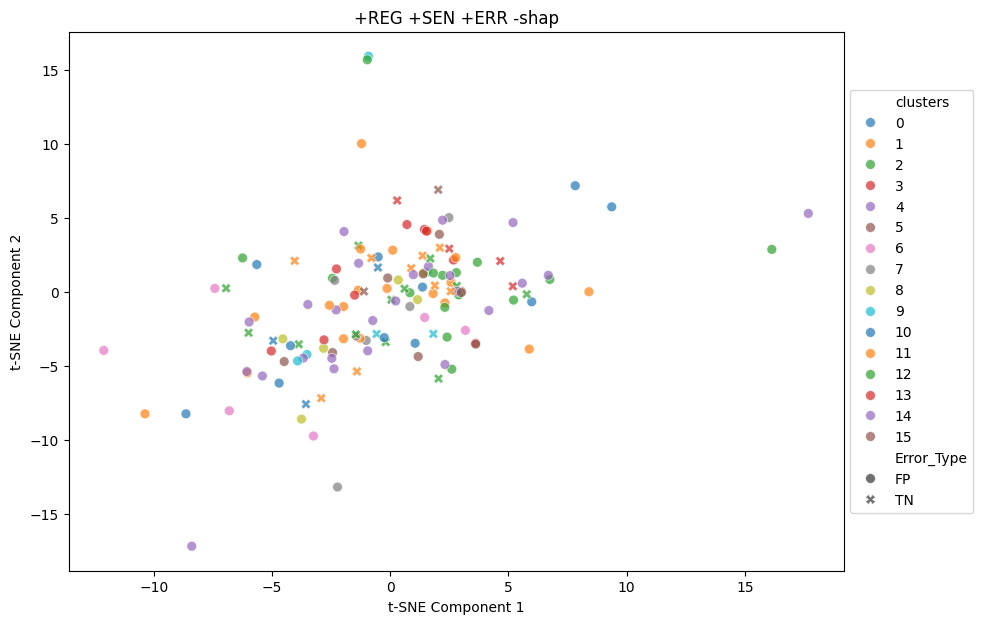

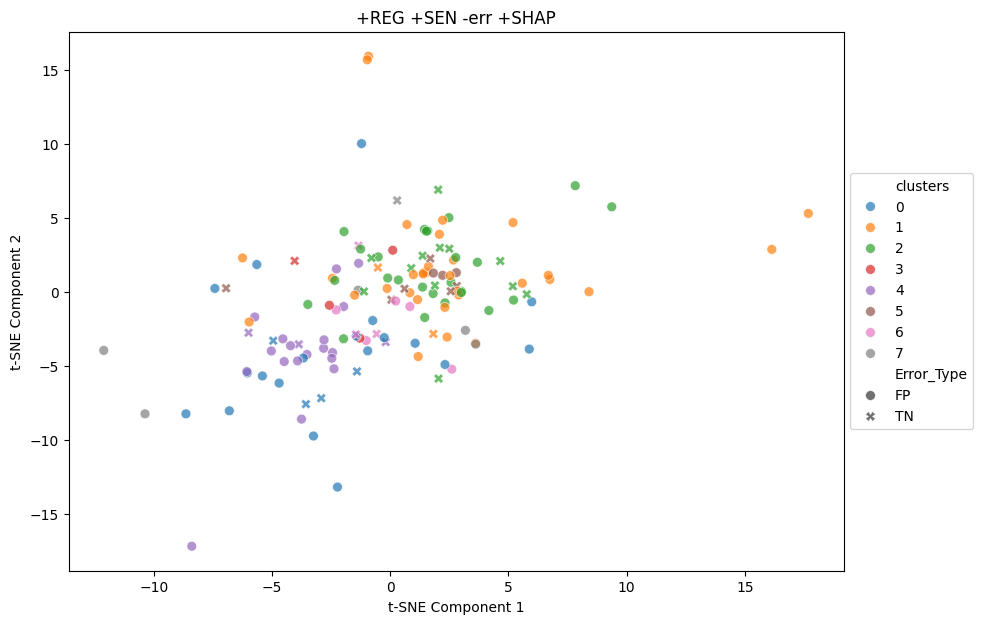

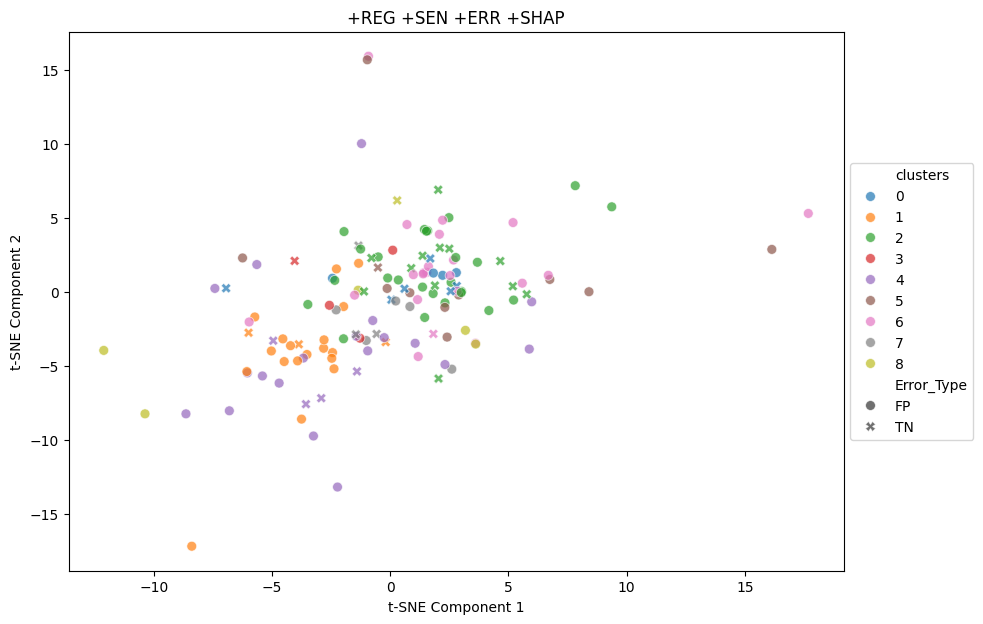

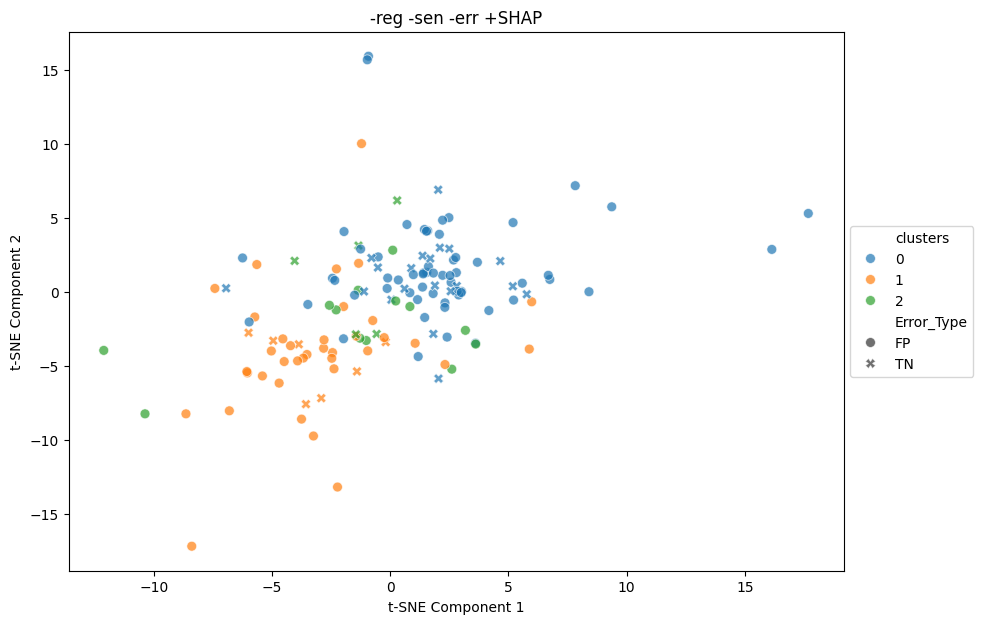

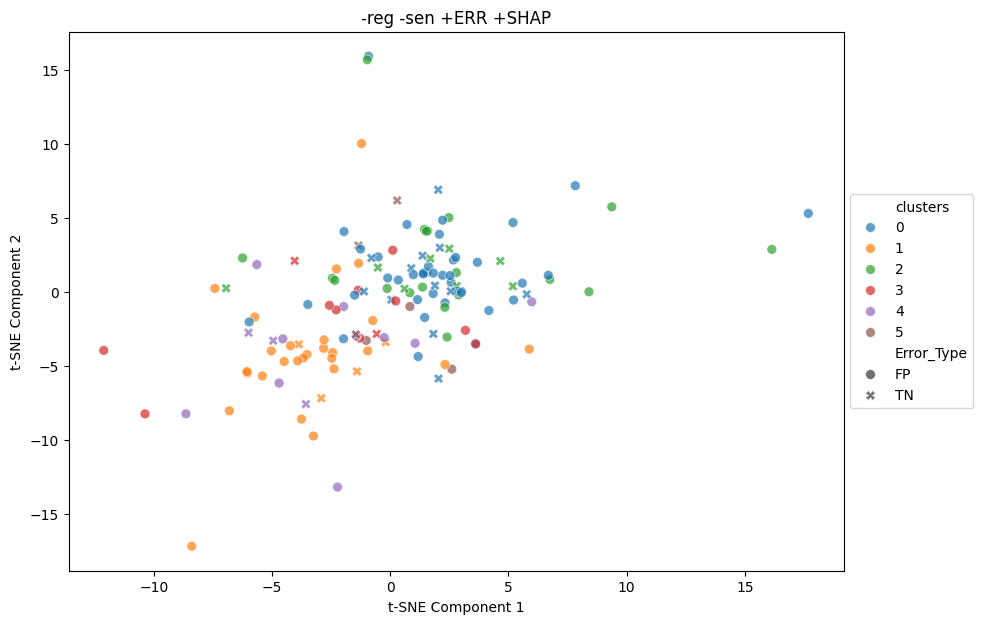

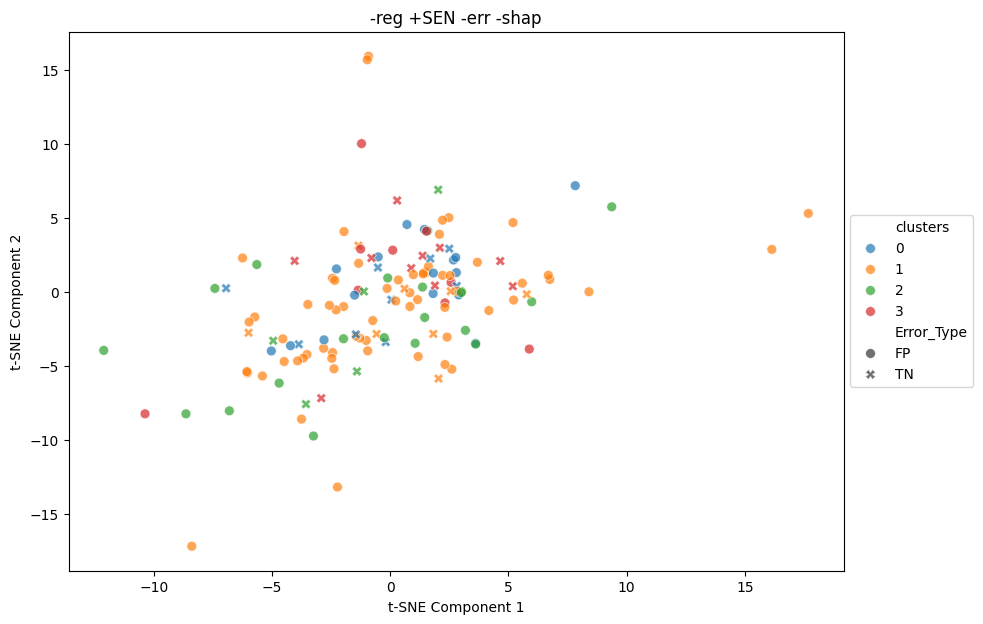

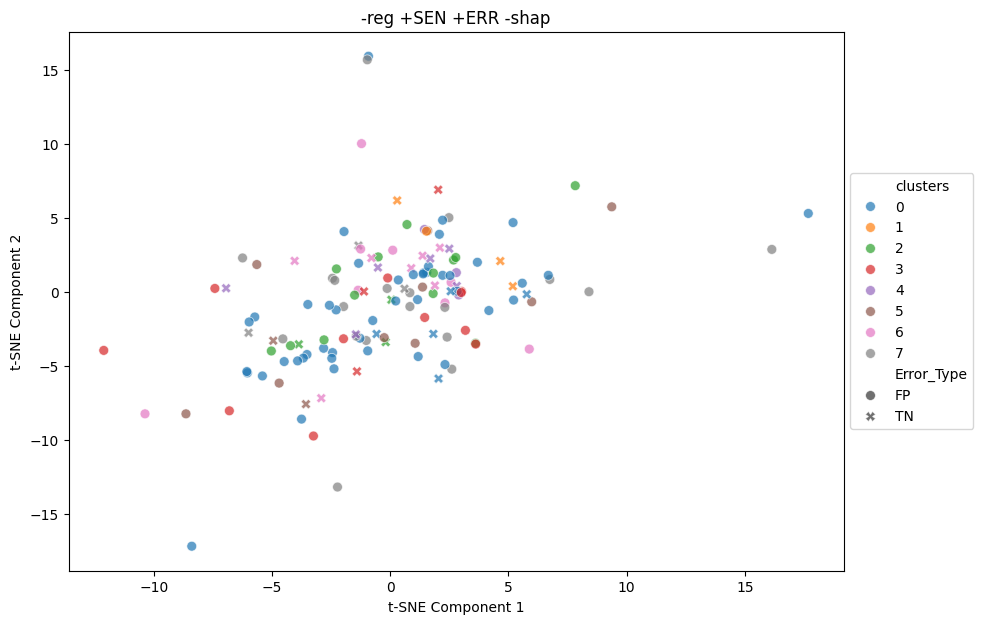

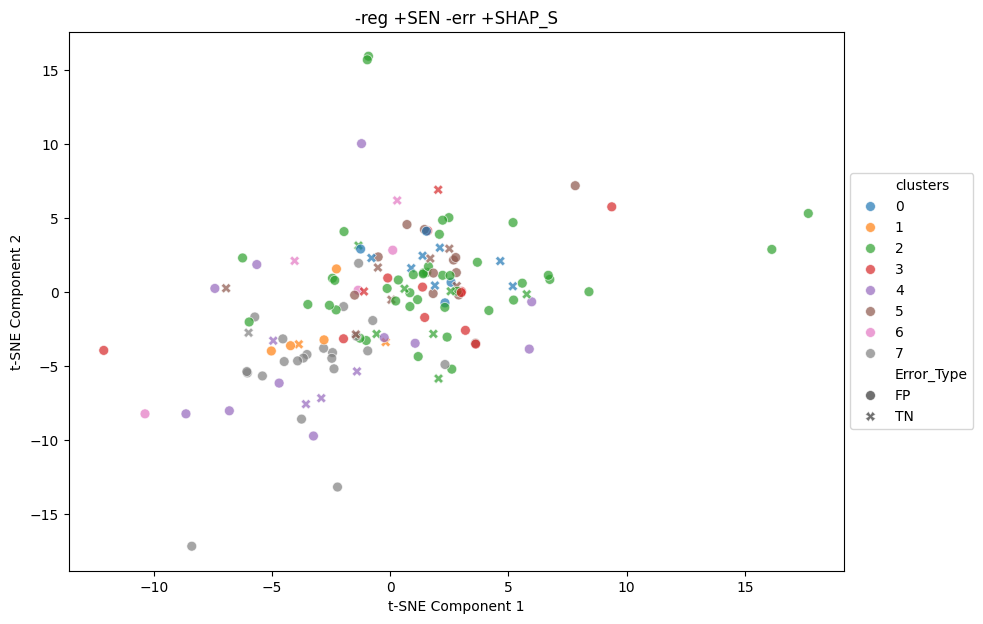

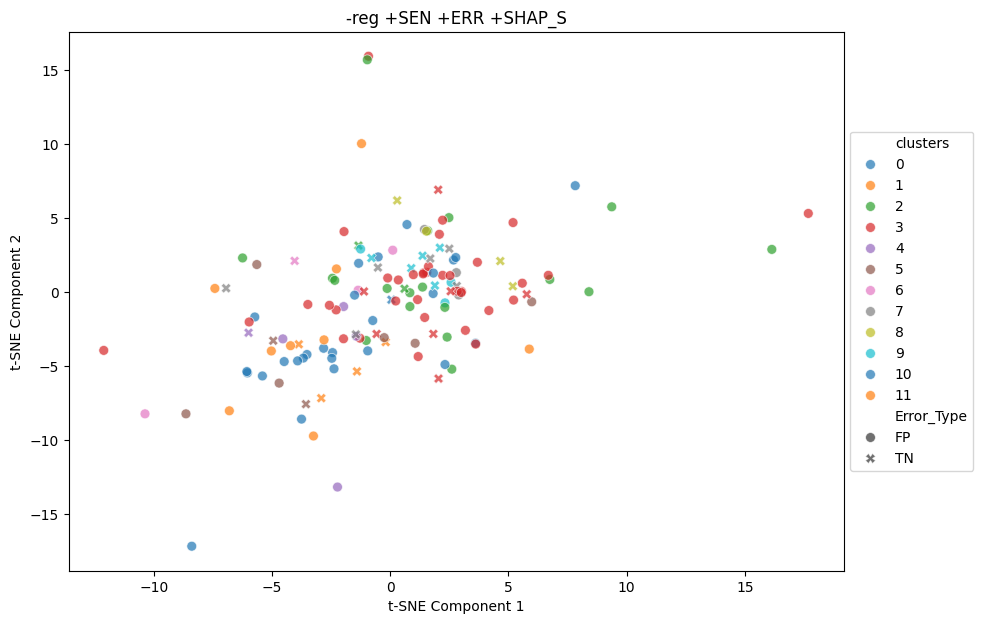

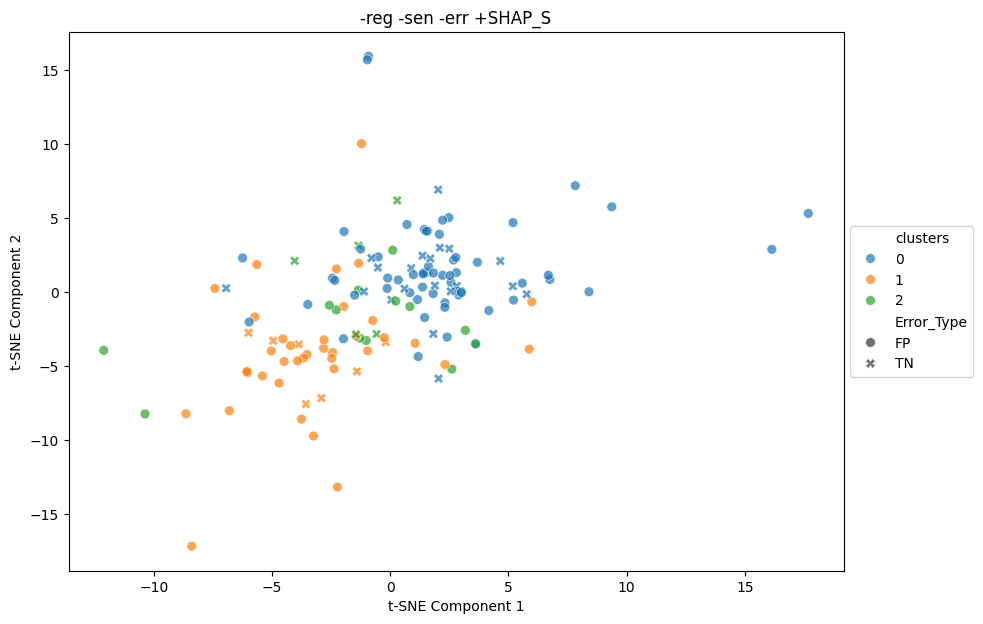

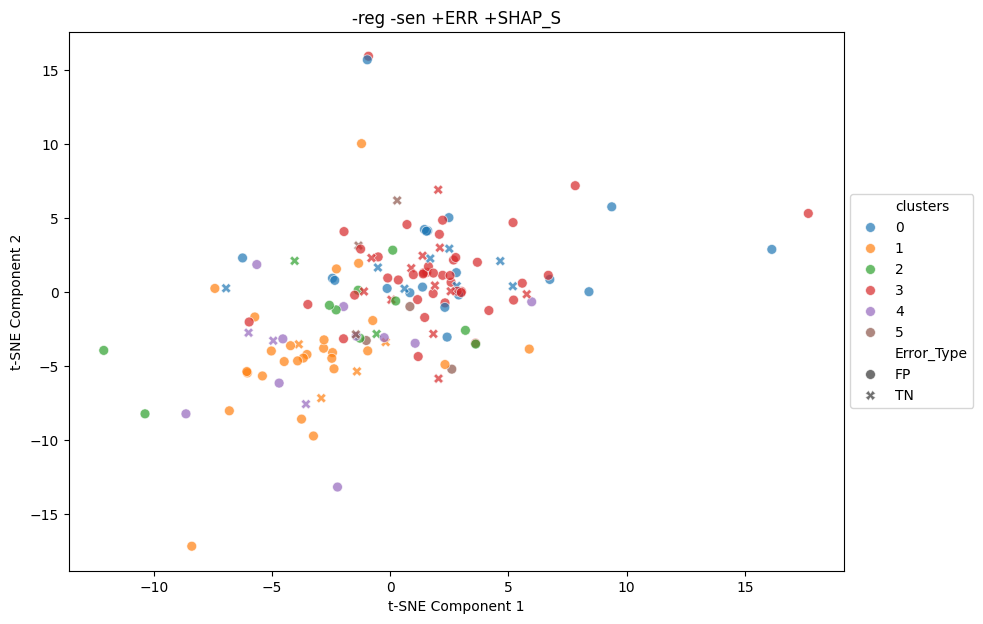

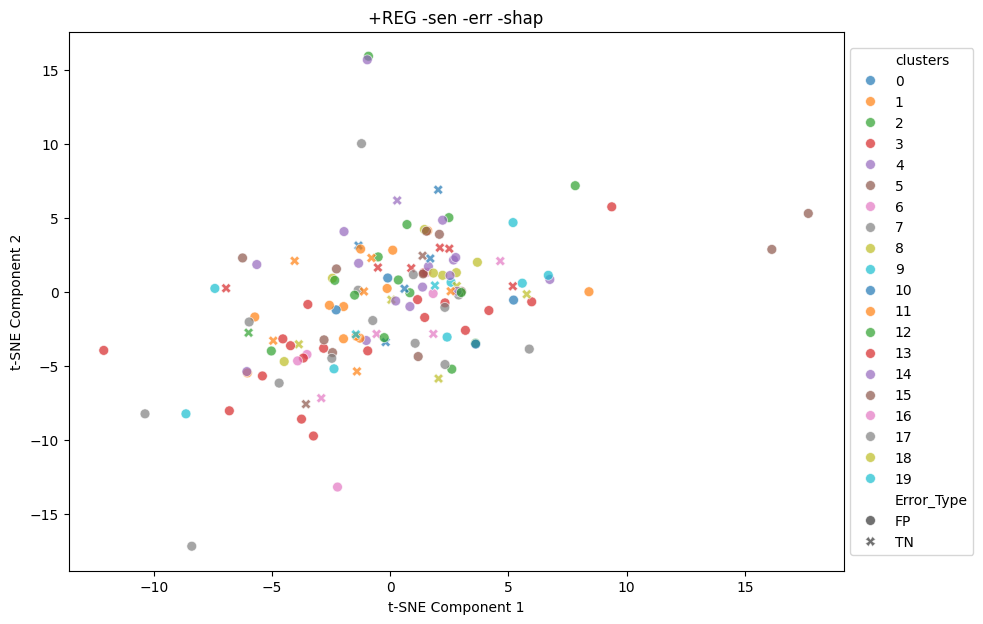

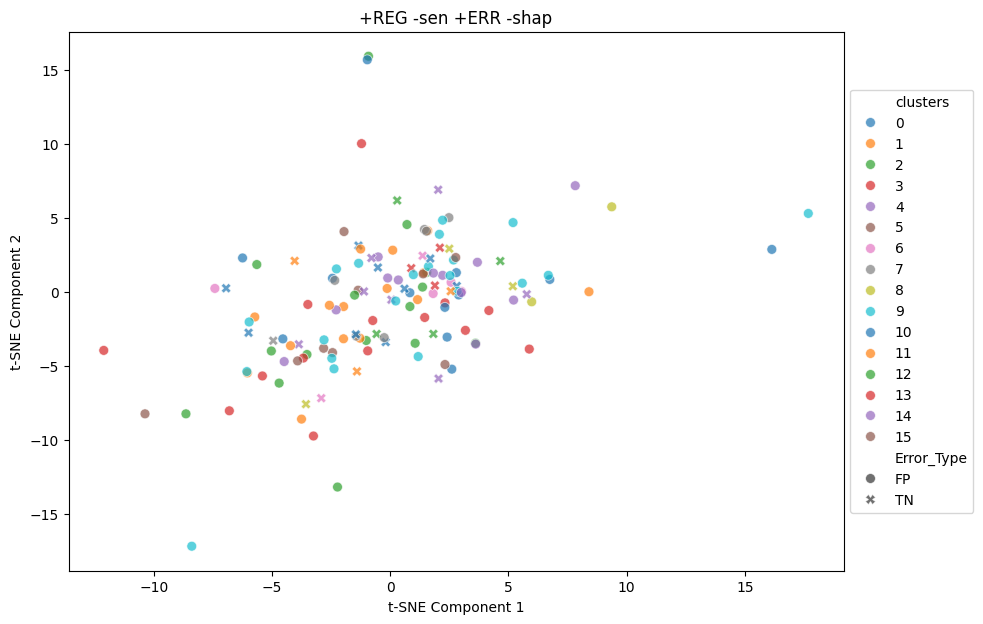

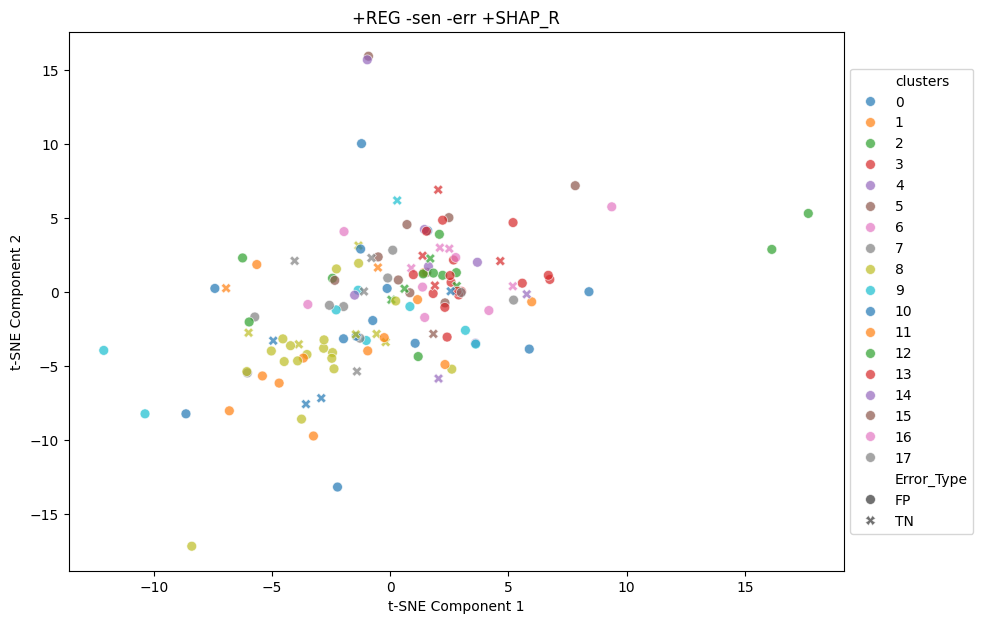

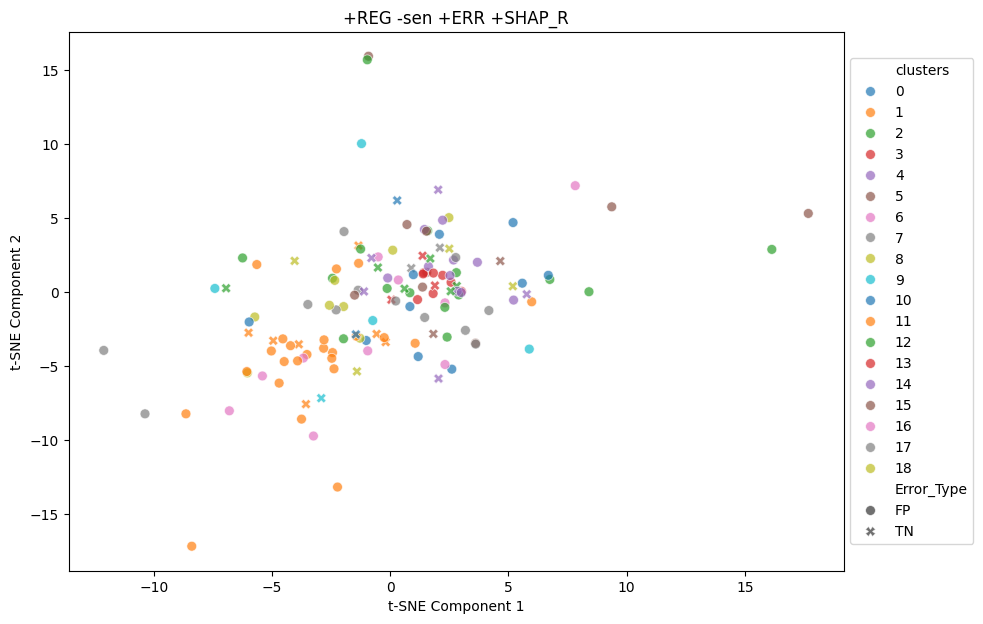

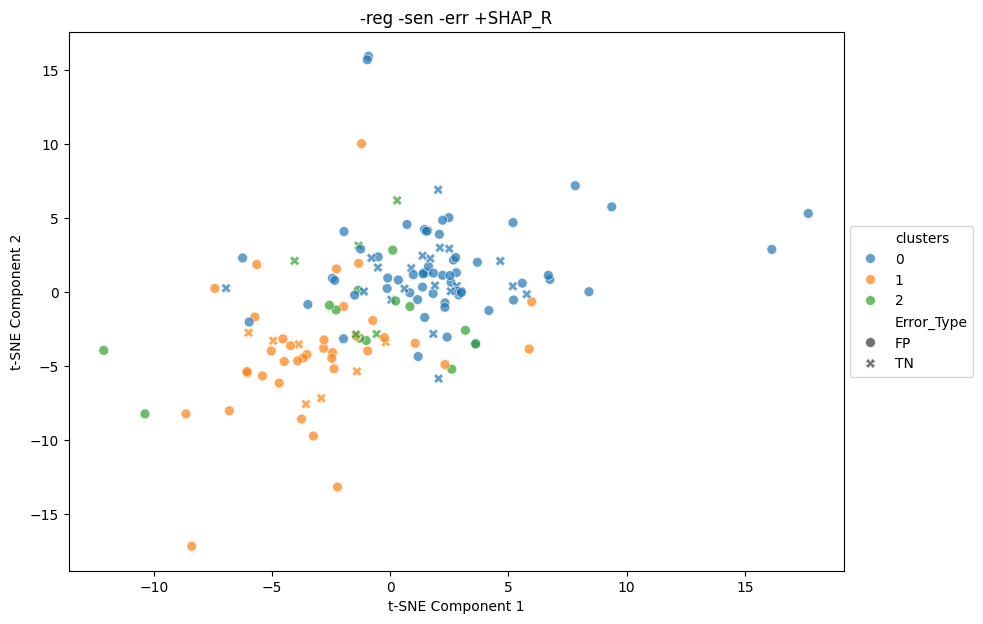

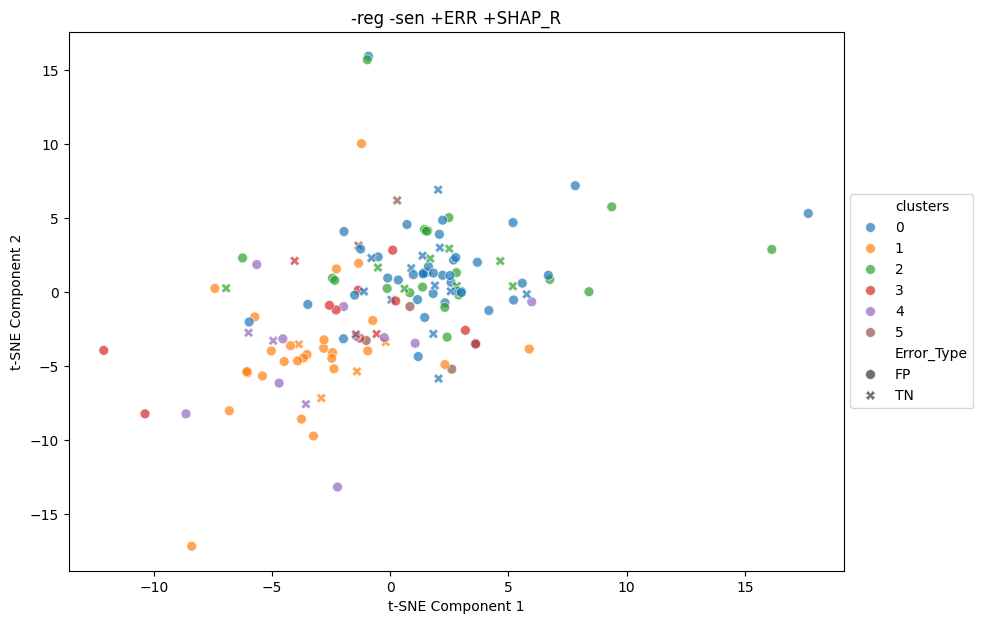

In [88]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TNFP_Kmeans_tSNE_')

# TPFN RESULTS

## Execute Experiments

In [89]:
min_splittable_cluster_prop = 0.01 #0.03
min_acceptable_cluster_prop = 0.03 #0.03, 0.01
min_acceptable_error_diff = 0.005 # 0,01, 0.005

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

from ctypes import Array
results = {'cond_name': [],
          'cond_descr': [],
          'cond_res': [],
          'cond_recap': []}
for i in range(0, len(exp_condition)):
  res = hbac_kmeans(TPFN_data.copy(deep=True),
                  columns_to_use = exp_condition['feature_set'][i],
                  error='errors',
                  min_splittable_cluster_prop = min_splittable_cluster_prop,
                  min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                  min_acceptable_error_diff = min_acceptable_error_diff,
                  max_iter=100,
                  random_state=seed_value)

  recap = make_recap(res, exp_condition['feature_set'][i])

  results['cond_name'].append(exp_condition['feature_set_name'][i])
  results['cond_descr'].append(exp_condition['feature_set_descr'][i])
  results['cond_res'].append(res)
  results['cond_recap'].append(recap)

##Chi-Square Tests TPFN data

In [90]:
chi_res = make_chi_tests(results)
chi_res_viz = chi_res.set_index('cond_name').drop('cond_descr', axis=1)
chi_res_viz = round(chi_res_viz, 6)
chi_res_viz

error   foreign     house    gender
cond_name                                                               
+REG +SEN  -err     -shap         0.000000  0.000000  0.000000  0.000000
+REG +SEN +ERR  -shap             0.000000  0.000000  0.000000  0.000000
+REG +SEN  -err    +SHAP          0.000223  0.000000  0.000000  0.000000
+REG +SEN +ERR  +SHAP             0.000060  0.000000  0.000000  0.000000
-reg    -sen    -err     +SHAP    0.920513  0.911682  0.132595  0.066154
-reg    -sen    +ERR  +SHAP       0.225881  0.975720  0.345662  0.041449
-reg    +SEN  -err     -shap      0.000000  0.000000  0.000000  0.000000
-reg    +SEN +ERR   -shap         0.000000  0.000000  0.000000  0.000000
-reg    +SEN  -err     +SHAP_S    0.000028  0.000000  0.000000  0.000000
-reg    +SEN +ERR  +SHAP_S        0.000251  0.000000  0.000000  0.000000
-reg    -sen    -err     +SHAP_S  0.920513  0.911682  0.132595  0.066154
-reg    -sen    +ERR  +SHAP_S     0.225881  0.975720  0.345662  0.041449
+REG -sen    -err     -shap       0.000697  0.312959  0.235324  0.000000
+REG -sen    +ERR  -shap          0.000007  0.170077  0.541459  0.000000
+REG -sen    -err     +SHAP_R     0.648235  0.946261  0.050687  0.000000
+REG -sen    +ERR  +SHAP_R        0.131508  0.906143  0.494373  0.000000
-reg    -sen    -err     +SHAP_R  0.920513  0.911682  0.132595  0.066154
-reg    -sen    +ERR  +SHAP_R     0.225881  0.975720  0.345662  0.041449

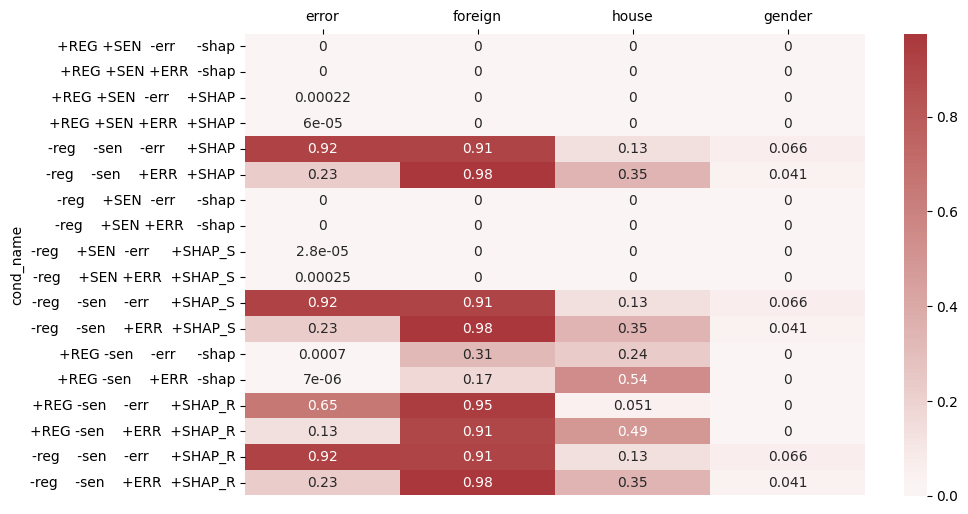

In [91]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(chi_res_viz, annot=True, center=0,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=False)
ax.xaxis.tick_top()
plt.yticks(rotation='horizontal')
plt.show()

## All Quality Metrics TPFN data

In [92]:
all_quali = recap_quali_metrics(chi_res, results, exp_condition)
all_quali_viz = all_quali.set_index('cond_name').drop('cond_descr', axis=1)
all_quali_viz = round(all_quali_viz, 6)
# all_quali_viz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

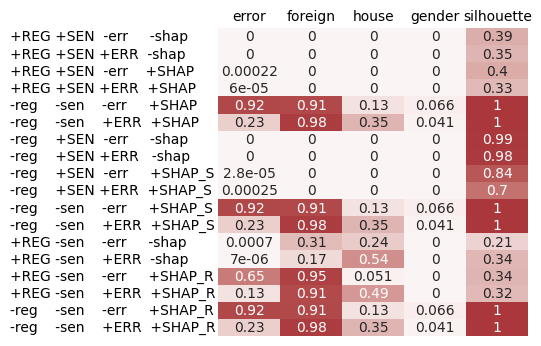

In [93]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(all_quali_viz, annot=True, center=0, cbar=False,
                cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', pad=150, length=0)
plt.yticks(ha='left')
plt.savefig('TPFN_Kmeans.png', bbox_inches='tight', pad_inches=0)
files.download('TPFN_Kmeans.png')
plt.show()

# DETAILED TPFN data


## One-vs-All cluster comparison TPFN data

0


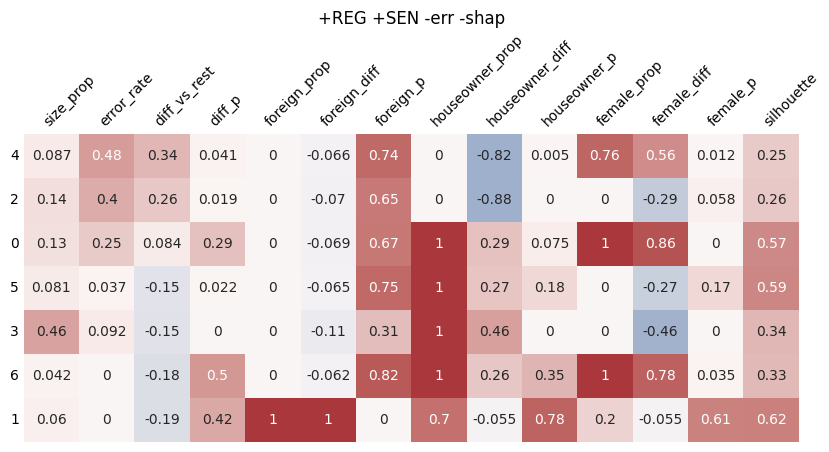

1


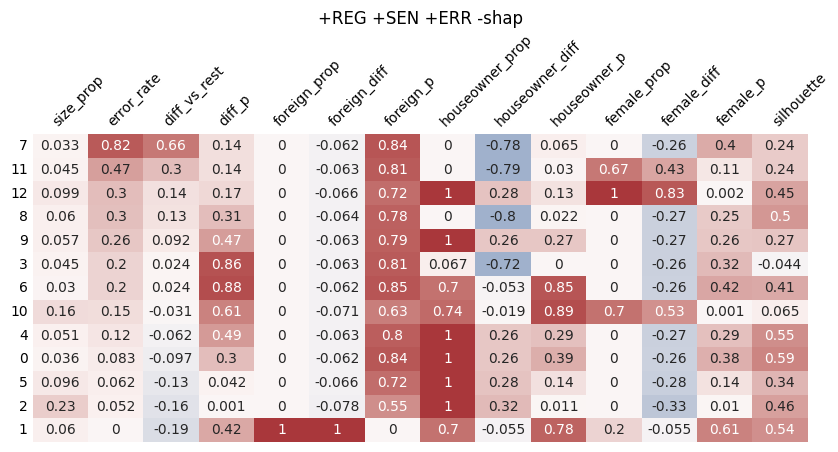

2


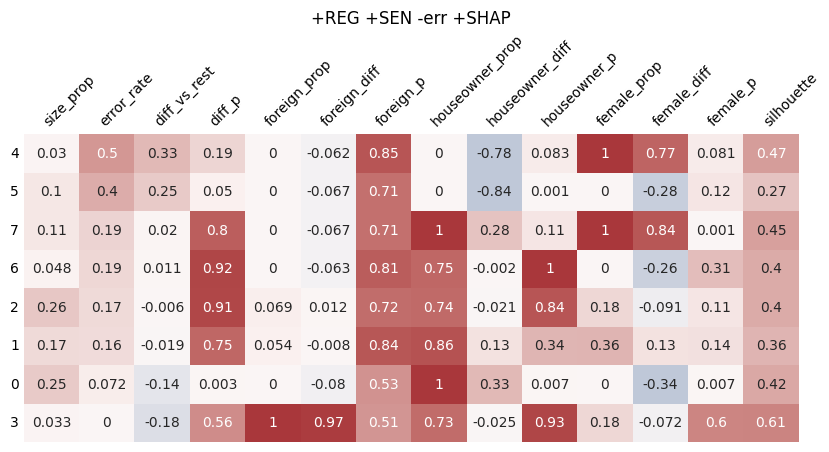

3


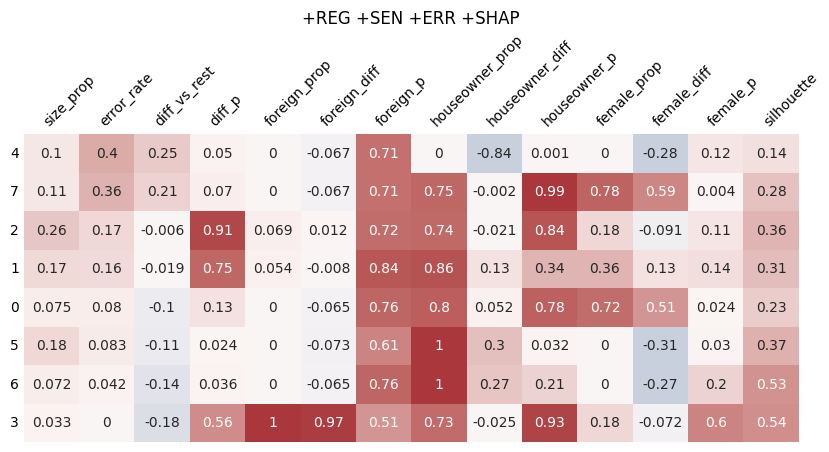

4


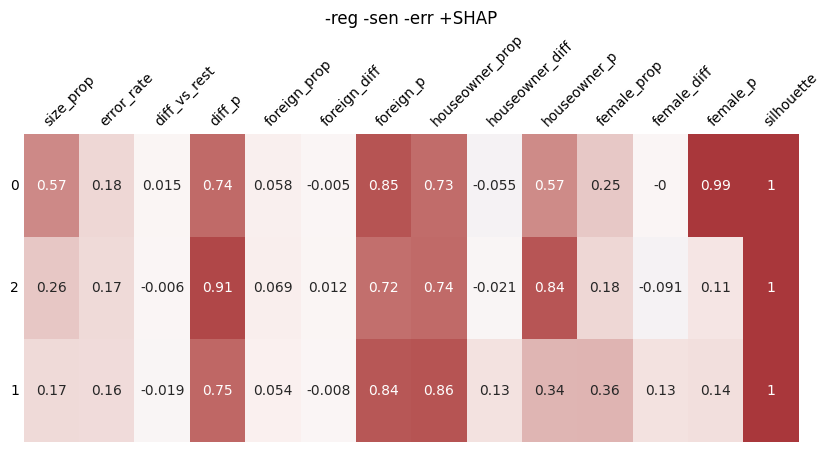

5


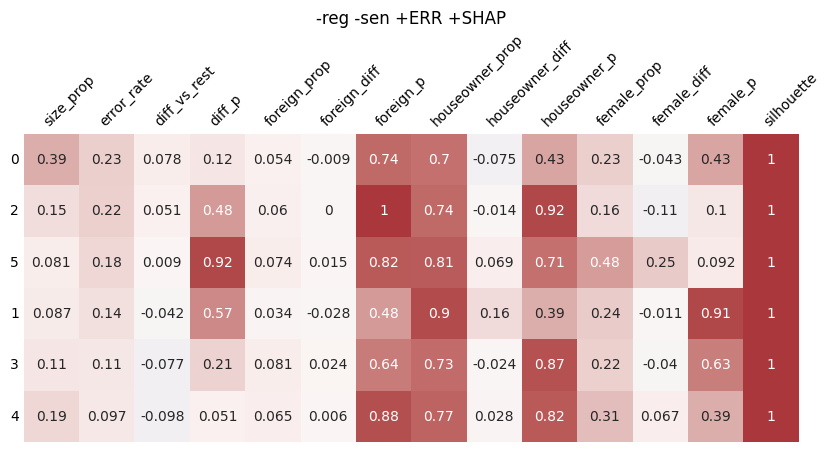

6


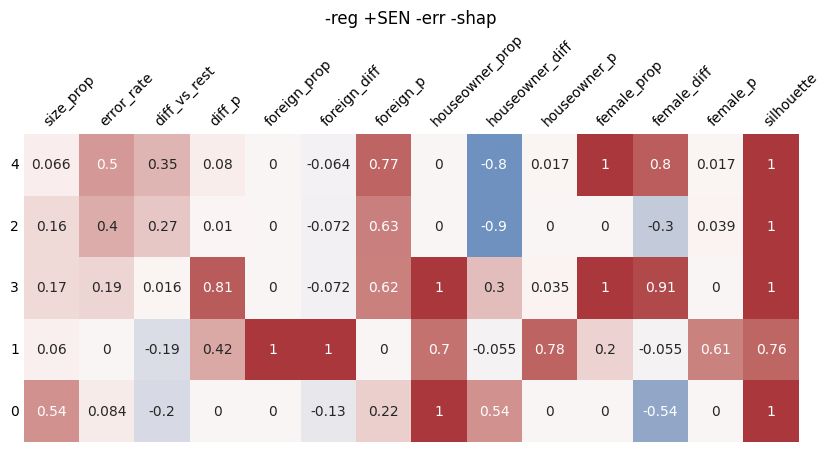

7


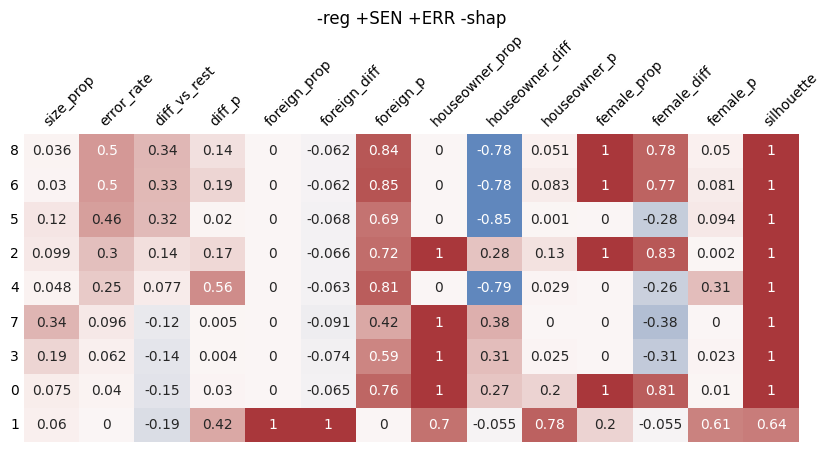

8


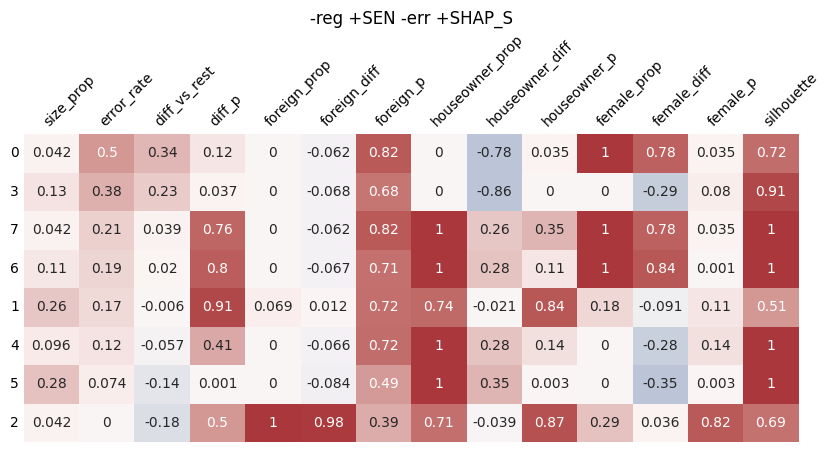

9


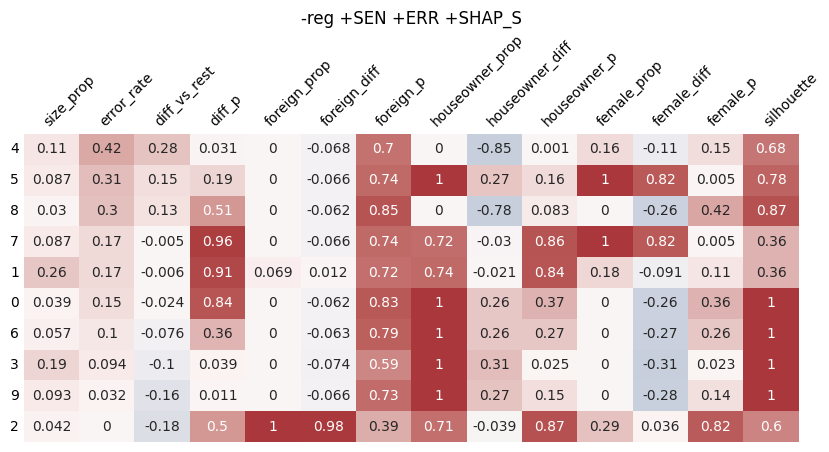

10


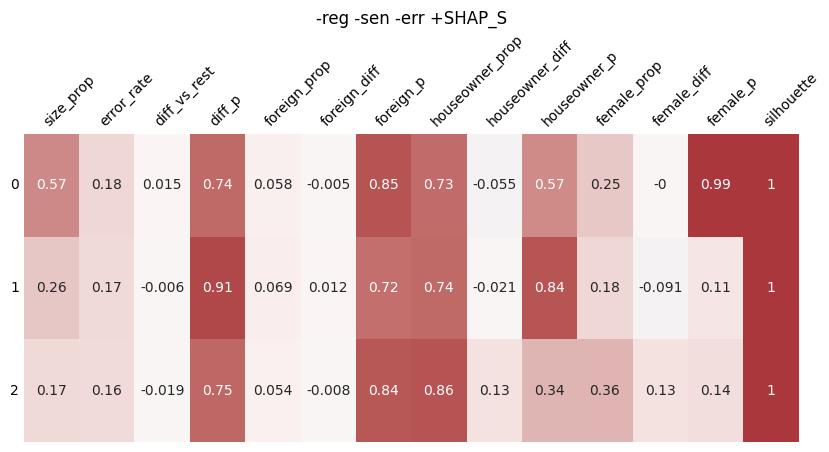

11


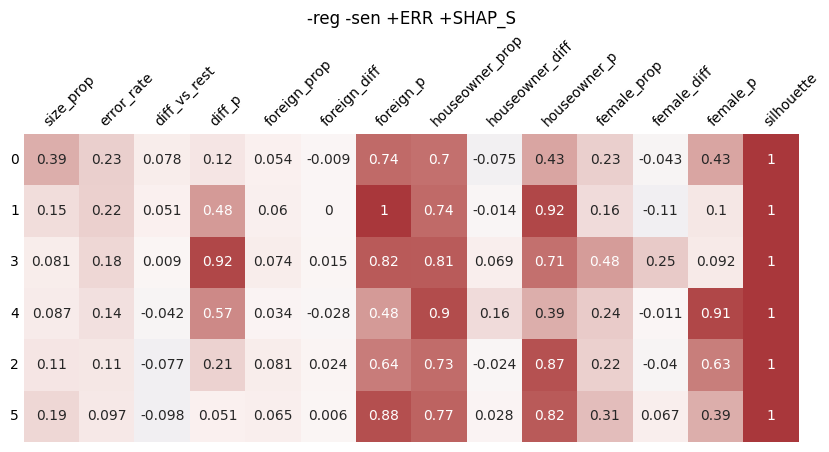

12


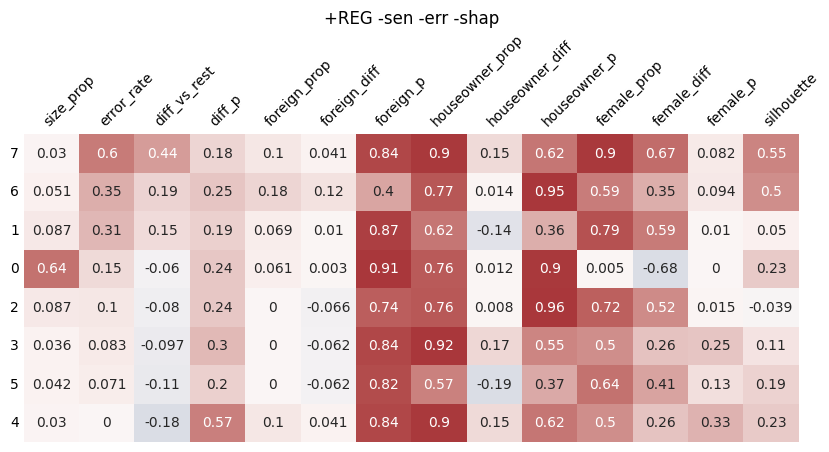

13


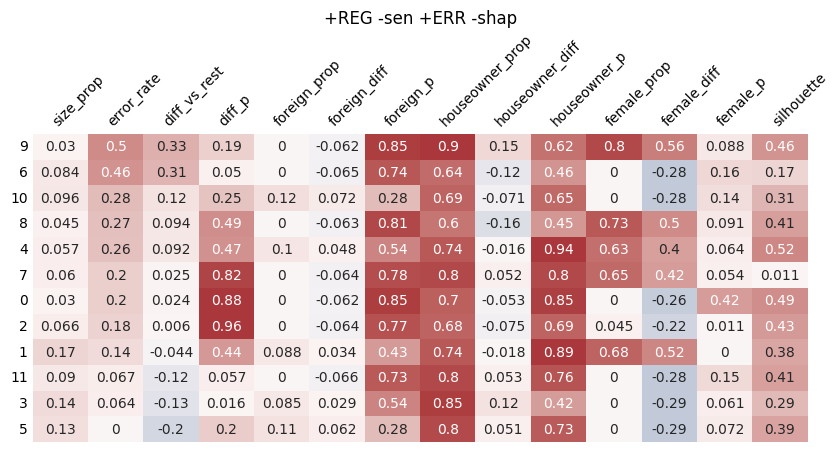

14


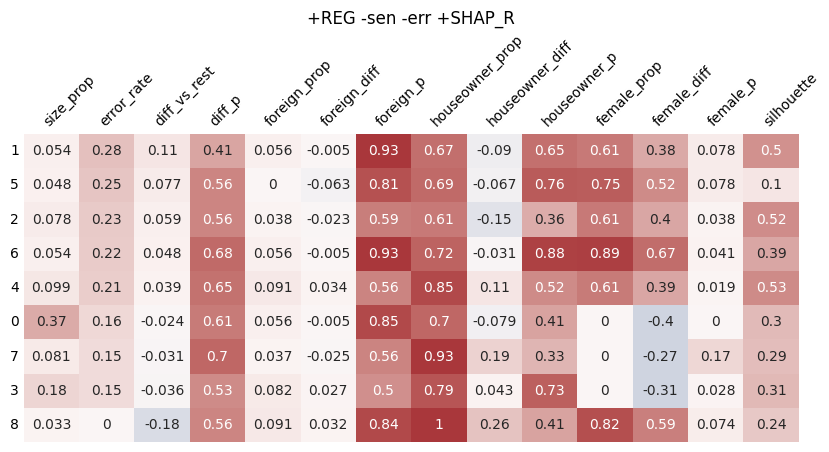

15


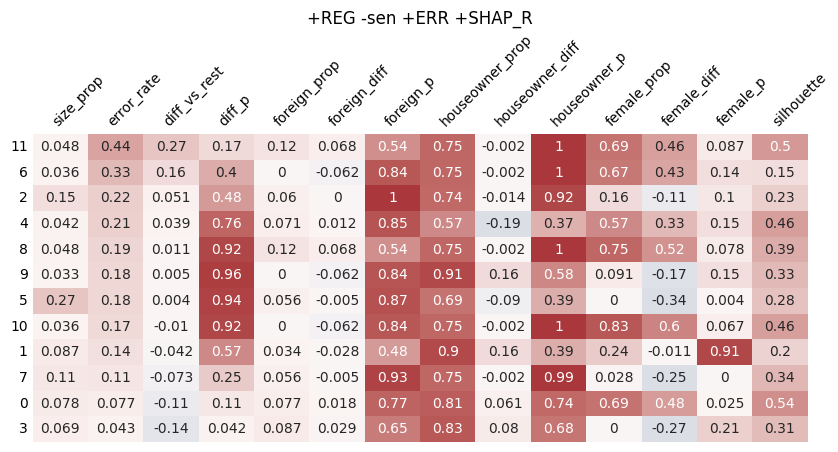

16


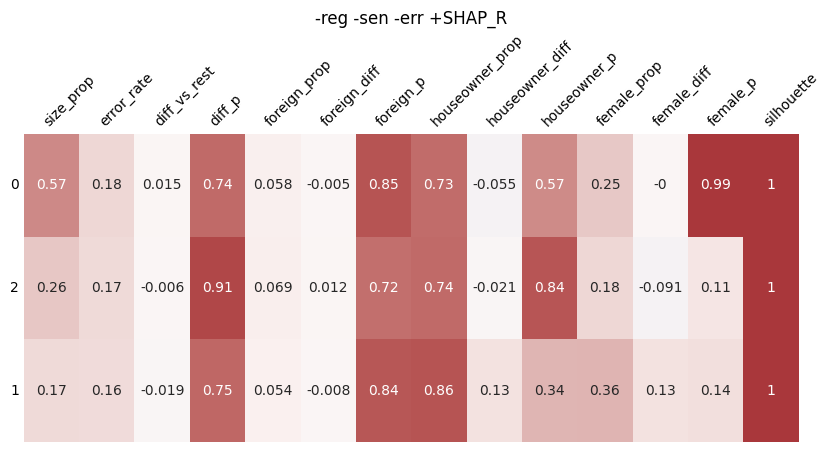

17


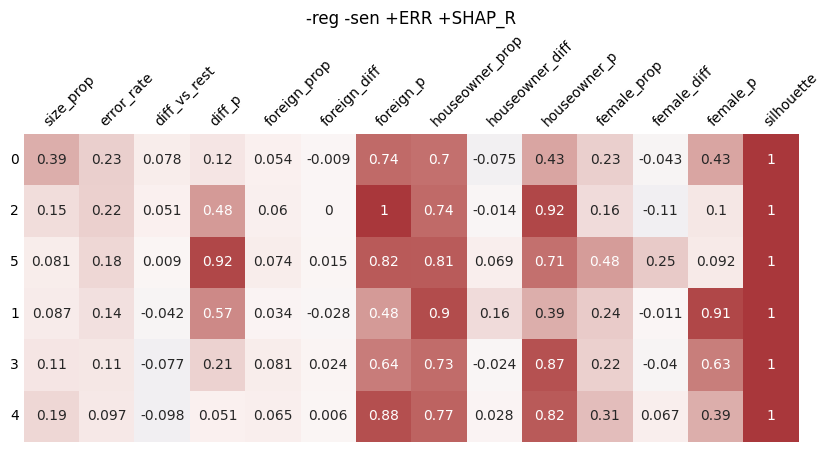

In [94]:
for i in range(0, len(exp_condition)):
  print(i)
  recap = results['cond_recap'][i].sort_values(by=['diff_vs_rest'], ascending=False)
  recap['count'] = recap['count']/recap['count'].sum()
  recap = recap.rename(columns={"count": "size_prop"})
  recap = recap.drop(['n_error','c'], axis=1)

  plt.figure(figsize=(10,4))
  ax = sns.heatmap(recap, annot=True, center=0, cbar=False,
                   cmap=sns.color_palette("vlag", as_cmap=True), robust=True)
  ax.set_title(re.sub(' +', ' ', results['cond_name'][i]))
  ax.xaxis.tick_top()
  ax.set(xlabel="", ylabel="")
  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', length=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
  plt.yticks(rotation='horizontal')
  plt.savefig('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png', bbox_inches='tight', pad_inches=0)
  plt.show()

## t-SNE TPFN data

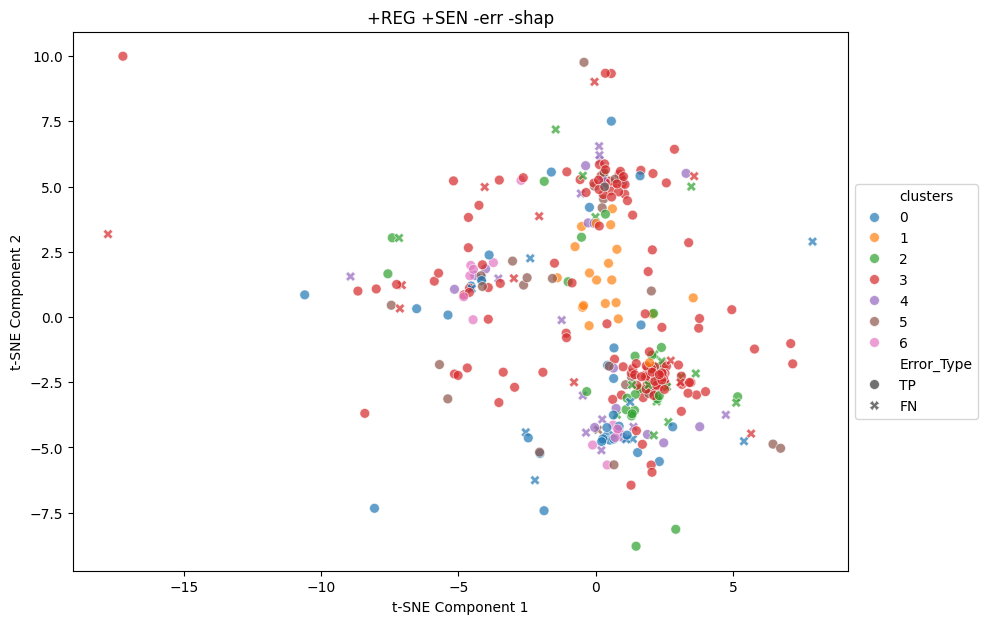

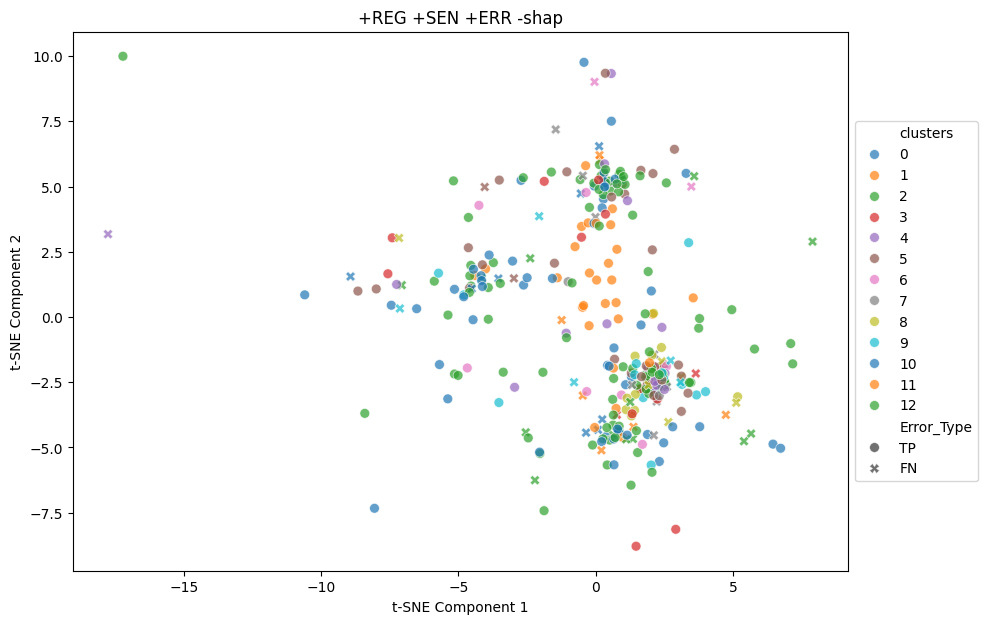

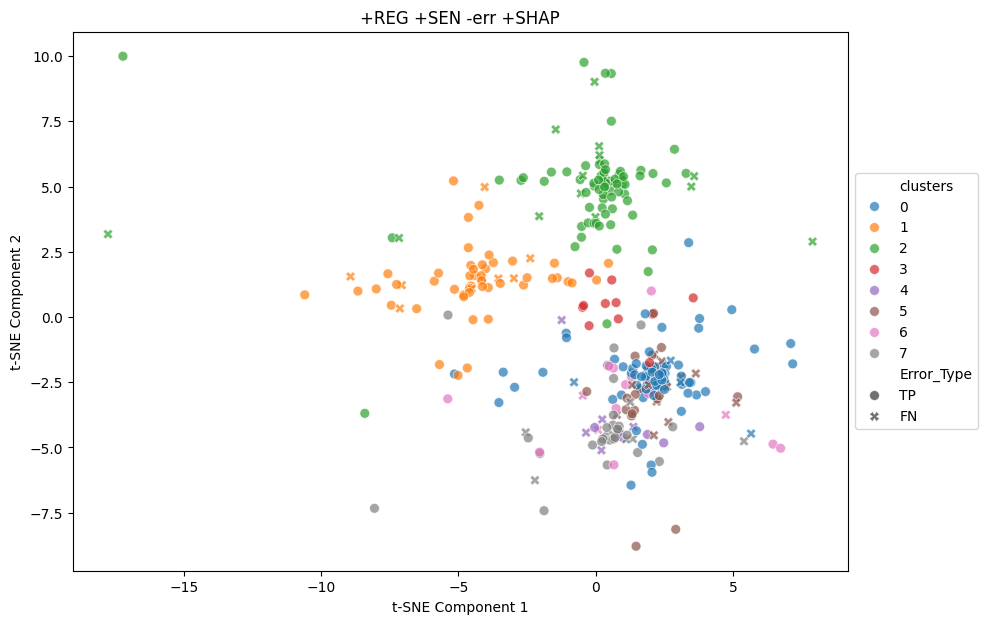

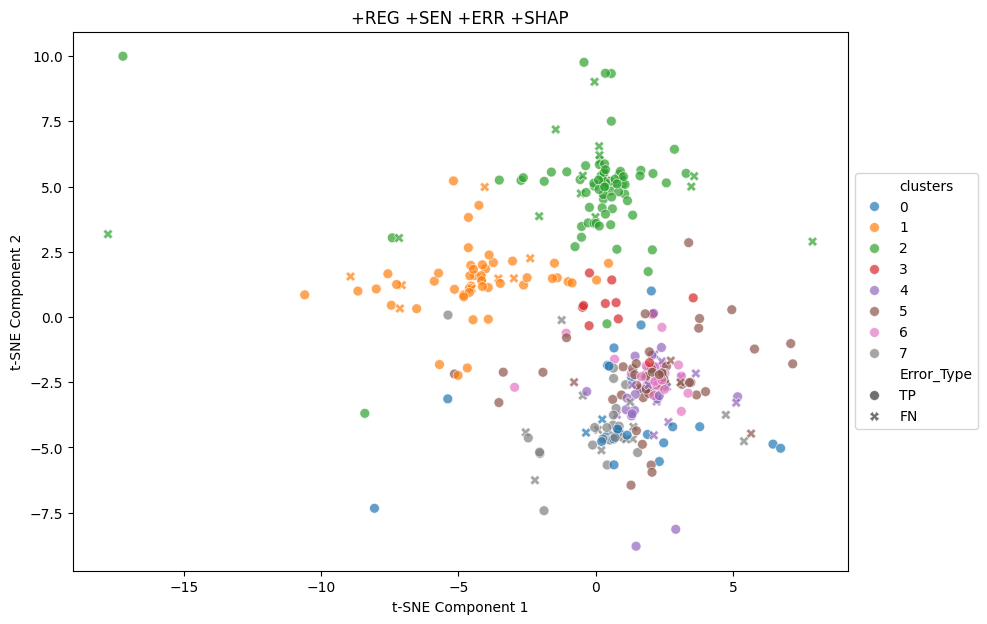

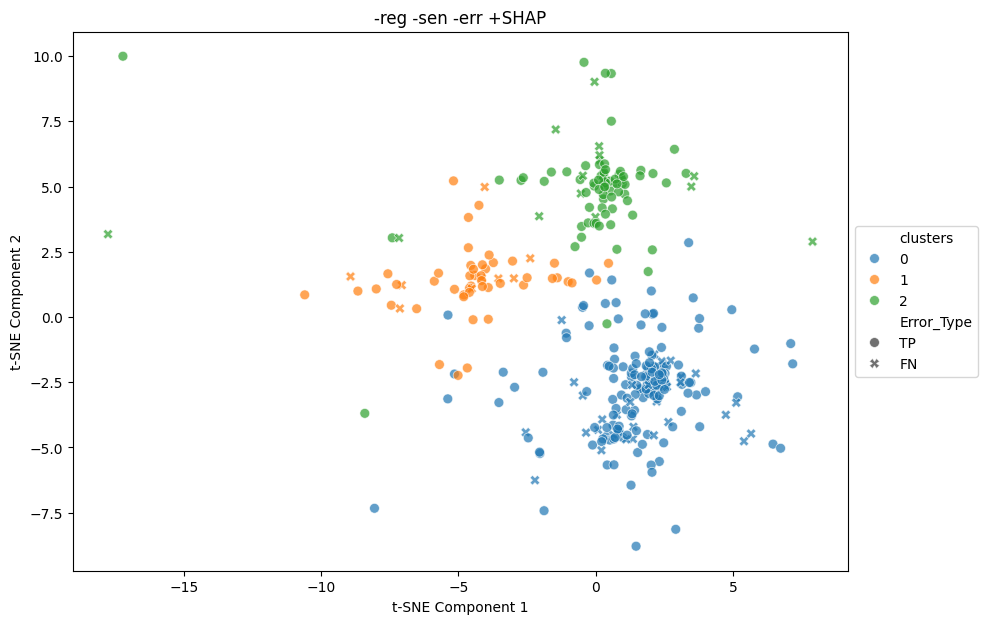

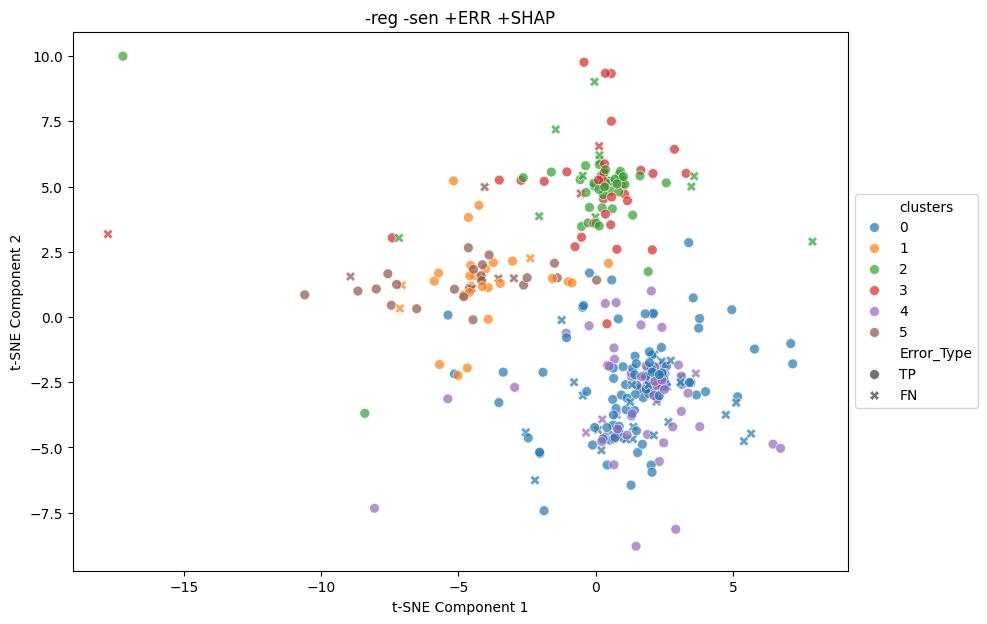

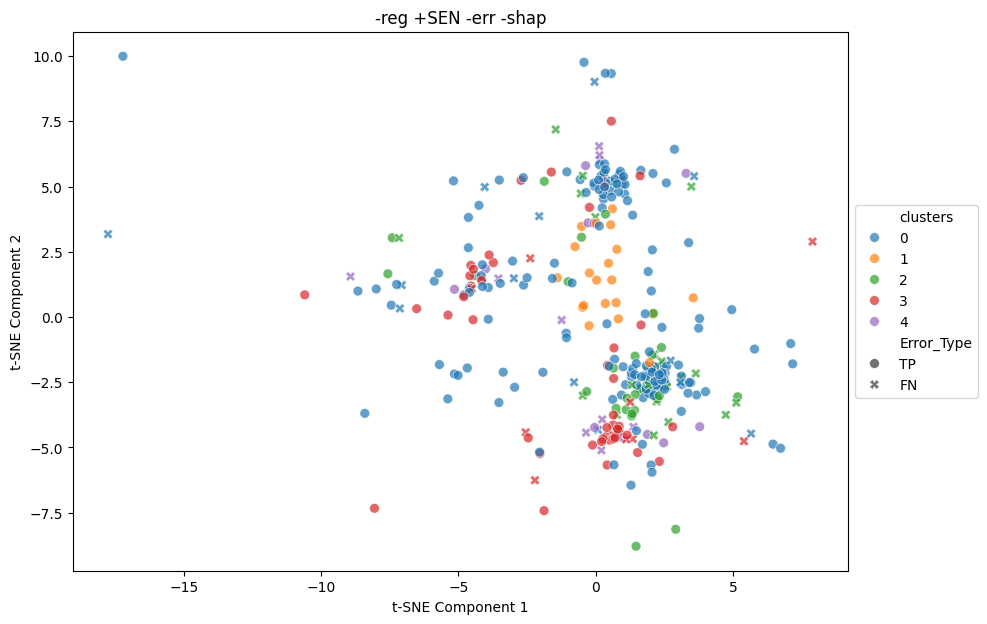

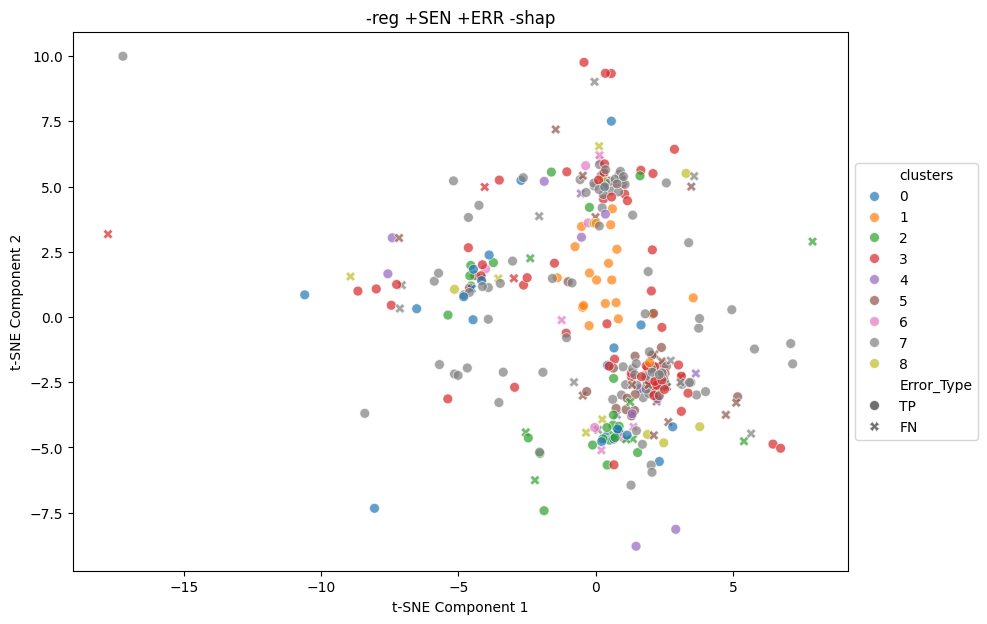

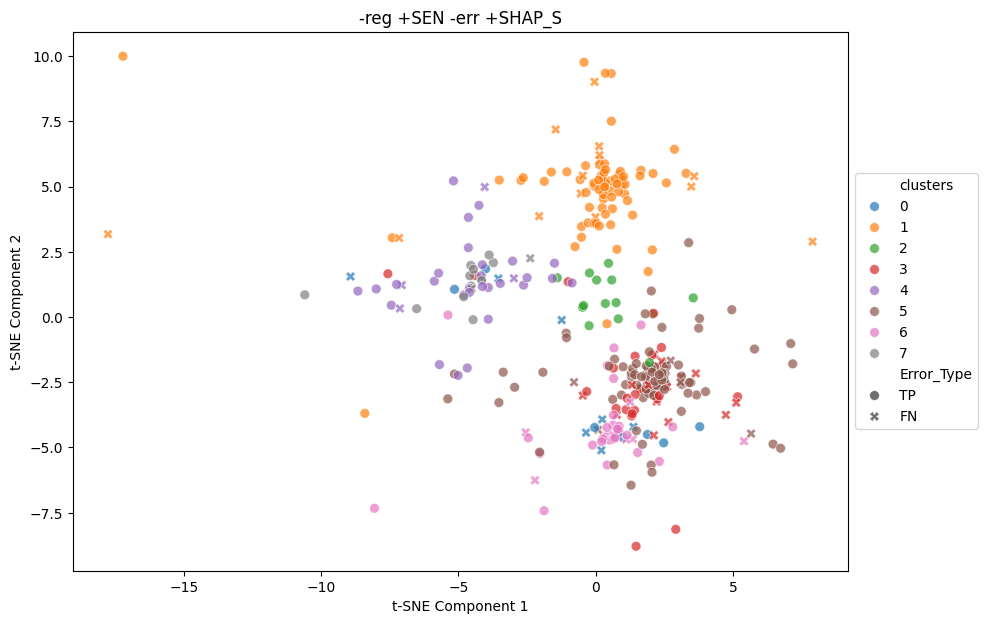

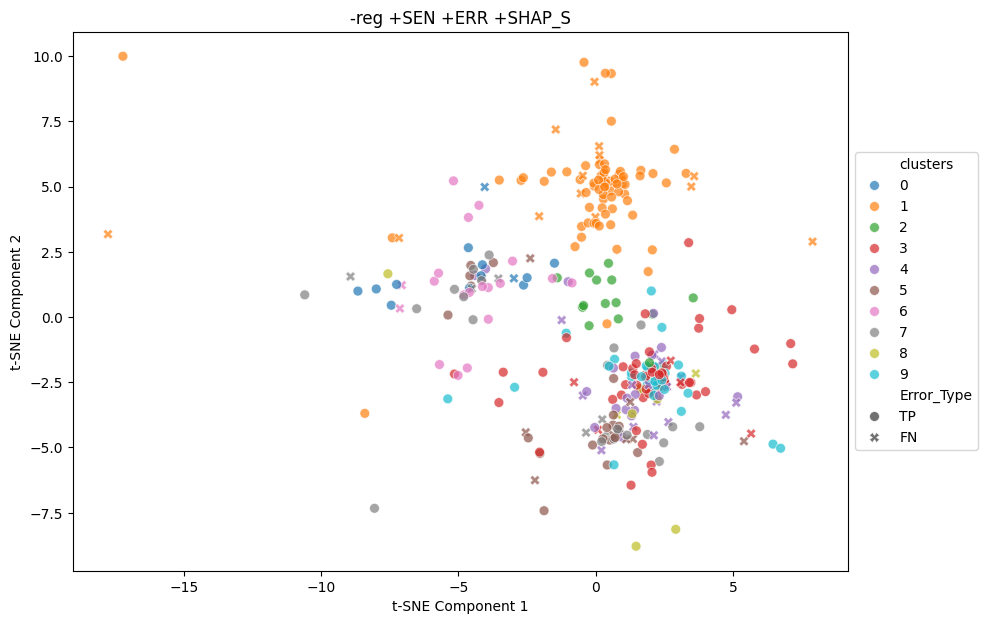

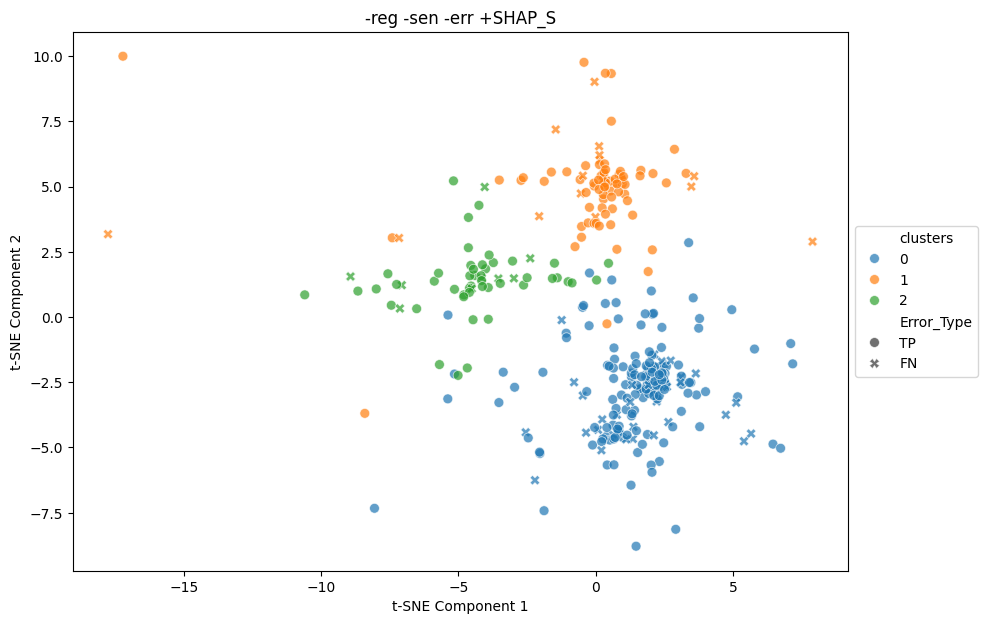

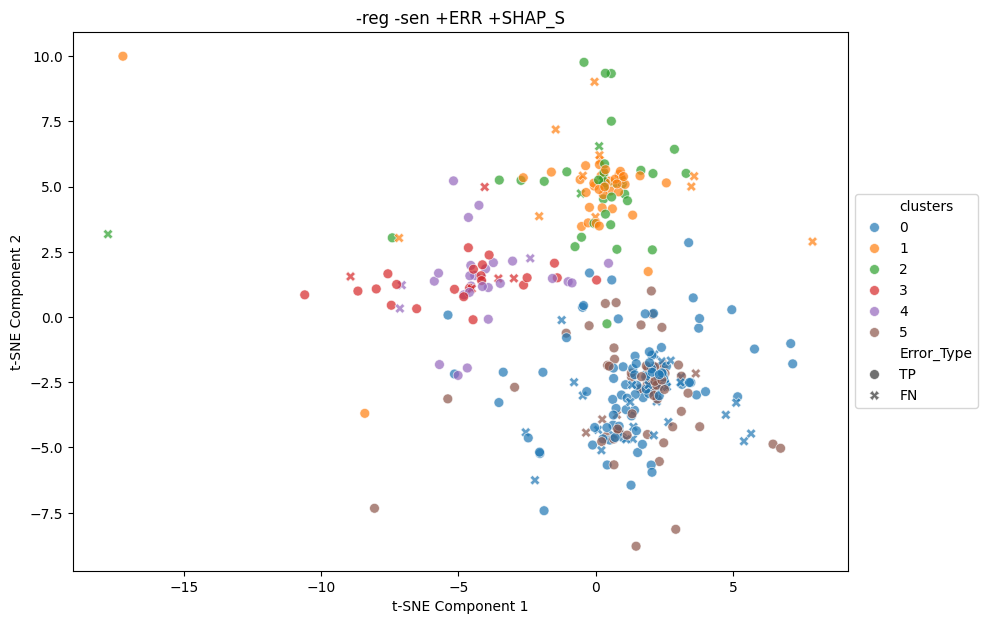

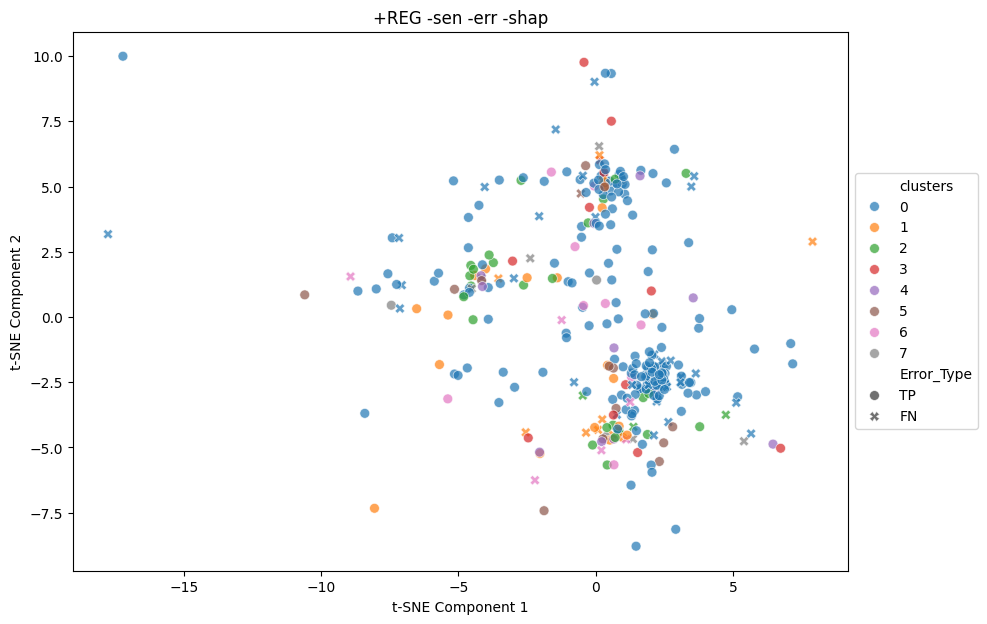

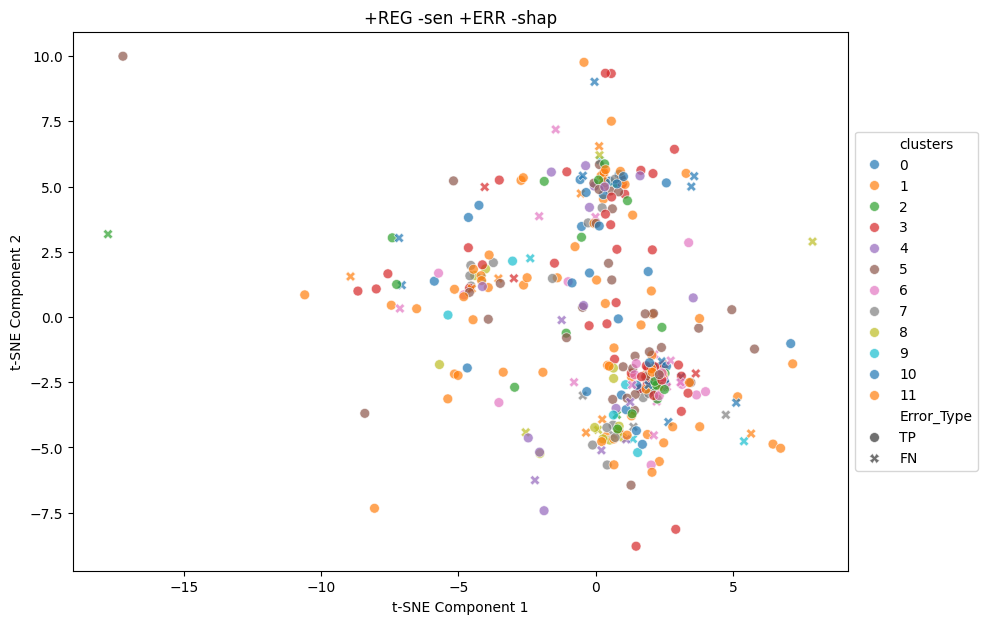

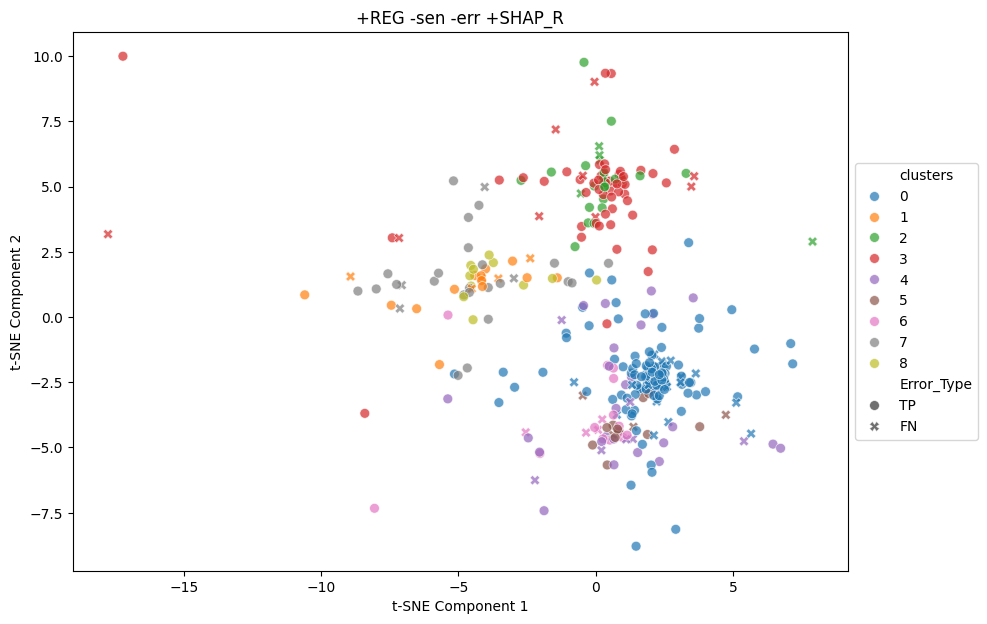

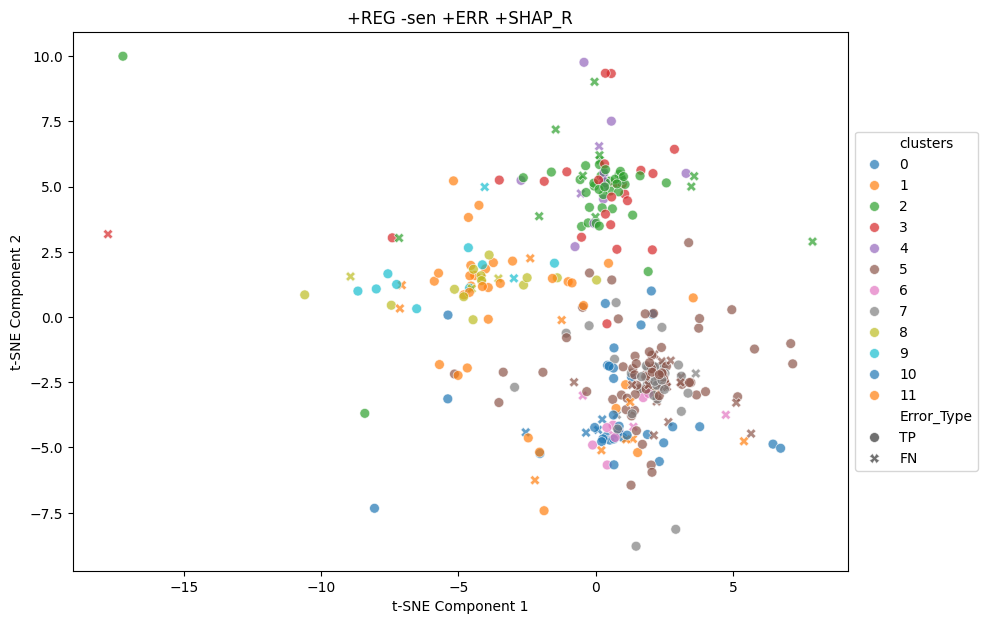

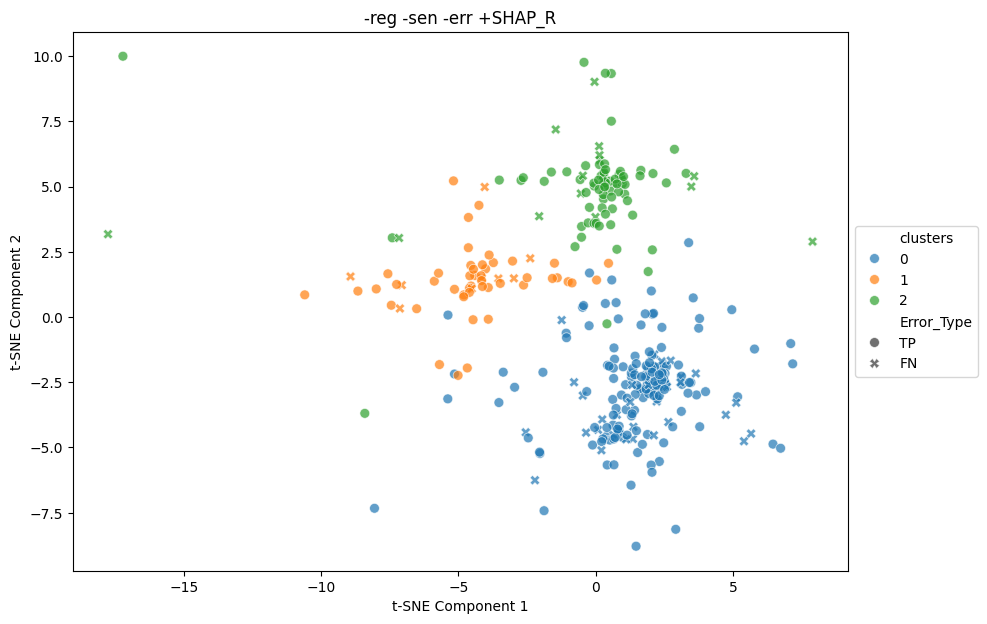

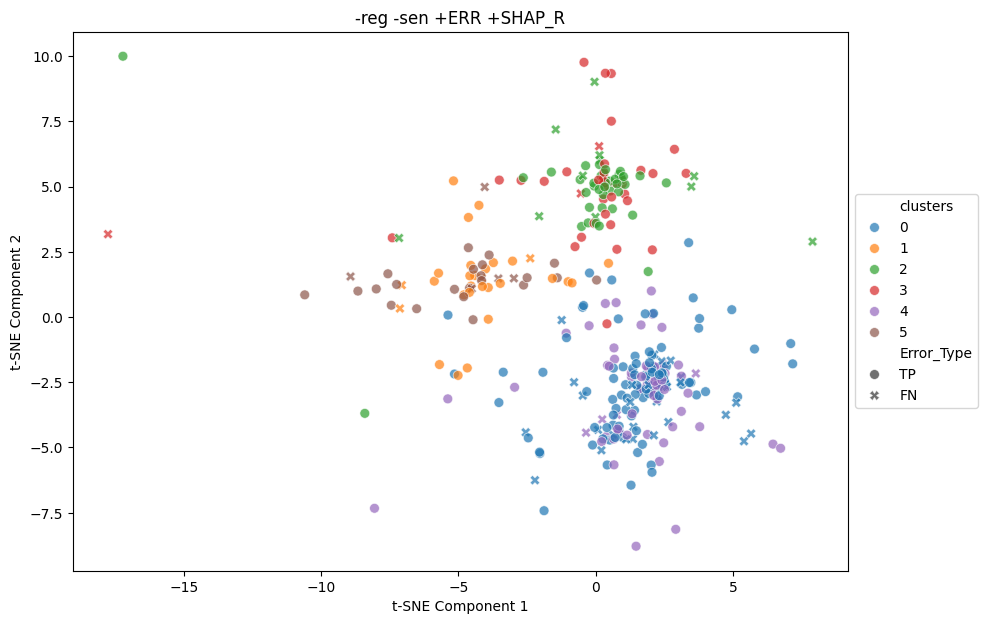

In [95]:
for i in range(0, len(exp_condition)):
  plt.figure(figsize=(10,7))
  tsne_plot_wClusters(results['cond_res'][i], title = re.sub(' +', ' ', results['cond_name'][i]),
                      alpha = 0.7, size = 50,
          tsne_columns = REG_scaled + DUMMY_scaled + SHAP_REG_scaled + SHAP_DUMMY_scaled,
          perplexity = 30, learning_rate = 200, n_iter = 250, fig_prefix='TPFN_Kmeans_tSNE_')

# DOWNLOAD FIGURES

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TNFP_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TNFP_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TNFP_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TPFN_Kmeans_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(0, 9):
  print(i)
  files.download('TPFN_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''

In [ ]:
'''for i in range(9, 18):
  print(i)
  files.download('TPFN_Kmeans_tSNE_'+re.sub(' +', '', results['cond_name'][i])+'.png')'''